# 何をするのか
Vtuberのハッシュタグを検索し、ツイート内容をCharacter-Level CNNにかけて分類器を作ります。  
ハッシュタグのないツイートがどんな話題についてのものなのか予測することができる機能を期待しています。  
目的としてはTwitterAPIに慣れたい＆自然言語処理っぽいことしたい＆Kerasを実装してみたい、といったところです。

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


スクレイピングのコードはこちら→https://github.com/Kiro02/TweetClasifier/blob/master/searcher.py

In [2]:
df_1 = pd.read_csv("キズナアイ.csv")
df_2 = pd.read_csv("輝夜月.csv")
df_3 = pd.read_csv("バーチャルのじゃロリ狐娘Youtuberおじさん.csv")
df_4 = pd.read_csv("ミライアカリ.csv")
df_5 = pd.read_csv("月ノ美兎.csv")

In [3]:
df = pd.concat([df_1,df_2,df_3,df_4,df_5])
df = df.reset_index()

In [4]:
del df["Unnamed: 0"] #よくわからない列ができてしまったので消す

In [5]:
df.head()

,index,hashtag,text
0,0,キズナアイ,#キズナアイ\nこれは前にアニメイト行った時に買ったやつ✨✨一目惚れ(♥ω♥*)ｷｭﾝｷｭﾝ...
1,1,キズナアイ,遂にやっちゃったキズナアイ面接っっ😆✨すっごいテンポ早いんだね！！！とろちゃんはついていける...
2,2,キズナアイ,#キズナアイ\nこの前ガチャガチャやった時のやつ！\n本当にかわいい！💕 https://t...
3,3,キズナアイ,#丸勘パジャマでどこまで行けるか\n#丸勘うちわ\n#のんのんびより\n#のんのんびよりギャ...
4,4,キズナアイ,「両極端は、あい交わる」 #キズナアイ


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 434 entries, 0 to 433
Data columns (total 3 columns):
index      434 non-null int64
hashtag    434 non-null object
text       434 non-null object
dtypes: int64(1), object(2)
memory usage: 10.2+ KB


・ツイートは最大１４０文字なのでそれを固定長にする（CNNなので可変長はNG)  
・ハッシュタグそのものは取り除く  
・データは生放送とかでワードに偏りが出てしまうので、いろいろな時期から撮りたい  
→サーバー上で定期的に動かすようにする  
・改行文字などを消去する  
・URLを除外  

In [7]:
#前処理はMeCabで。
import MeCab
m = MeCab.Tagger ("-Ochasen")
#テスト
print(m.parse(df.loc[2,["text"]][0]))

#	#	#	名詞-サ変接続		
キズナアイ	キズナアイ	キズナアイ	名詞-一般		
この	コノ	この	連体詞		
前	マエ	前	名詞-副詞可能		
ガチャガチャ	ガチャガチャ	ガチャガチャ	名詞-一般		
やっ	ヤッ	やる	動詞-自立	五段・ラ行	連用タ接続
た	タ	た	助動詞	特殊・タ	基本形
時	トキ	時	名詞-非自立-副詞可能		
の	ノ	の	助詞-連体化		
やつ	ヤツ	やつ	名詞-代名詞-一般		
！	！	！	記号-一般		
本当に	ホントウニ	本当に	副詞-一般		
かわいい	カワイイ	かわいい	形容詞-自立	形容詞・イ段	基本形
！	！	！	記号-一般		
💕	💕	💕	記号-一般		
https	https	https	名詞-固有名詞-組織		
://	://	://	名詞-サ変接続		
t	t	t	名詞-一般		
.	.	.	名詞-サ変接続		
co	co	co	名詞-一般		
/	/	/	名詞-サ変接続		
cmUnsIXl	cmUnsIXl	cmUnsIXl	名詞-一般		
1	1	1	名詞-数		
o	o	o	名詞-固有名詞-組織		
EOS



In [8]:
string="#キズナアイ\nこの前ガチャガチャやった時のやつ！\n本当にかわいい！"
string.replace("\n","")
string.strip()
print(string)

#キズナアイ
この前ガチャガチャやった時のやつ！
本当にかわいい！


In [9]:
test = [ord(x) for x in string.strip()] #文章をベクトル化
print(test)
print(len(string),len(test))

[35, 12461, 12474, 12490, 12450, 12452, 10, 12371, 12398, 21069, 12460, 12481, 12515, 12460, 12481, 12515, 12420, 12387, 12383, 26178, 12398, 12420, 12388, 65281, 10, 26412, 24403, 12395, 12363, 12431, 12356, 12356, 65281]
33 33


In [10]:
def replace_words(dataframe, word1, word2):
    """
    ツイート内のword1をword2置換
    """
    for i in range(len(dataframe.loc[:,["text"]])):
        dataframe.loc[i,["text"]] = dataframe.loc[i,["text"]].astype(str)[0].replace(str(word1),str(word2))
    return dataframe

In [11]:
df = replace_words(df, "\n", "") #改行記号削除
#ハッシュタグ削除
for vtuber in ["キズナアイ","輝夜月","ミライアカリ","バーチャルのじゃロリ狐娘Youtuberおじさん","月ノ美兎"]:
    df = replace_words(df, ("#" + vtuber), "")
df.tail()

,index,hashtag,text
429,95,月ノ美兎,#すーぱーそに子 まさかのコラボhttps://t.co/Mpw3WZsigw
430,96,月ノ美兎,すき https://t.co/WjyXWgOhzM
431,97,月ノ美兎,みとみとが真面目に話してるところに上から100トンがポンポン落ちてきてるの面白すぎる
432,98,月ノ美兎,月ノ美兎の放課後ラジオ #6 配信を開始しました #委員長すき #にじさんじ https:...
433,99,月ノ美兎,公式ﾗｲﾊﾞｰ情報まとめ9月9日更新https://t.co/WasJr6KzCJ#鈴谷アキ...


In [12]:
#ツイートの固定長ベクトル化
def string2vec(dataframe):
    array = np.arange(140).reshape(1,140)
    for i in range(len(dataframe.loc[:,["text"]])): #ベクトル化
        string_vec = [ord(x) for x in dataframe.loc[i,["text"]].astype(str)[0].strip()]
        while len(string_vec) < 140:     #140の長さで固定するためのゼロパディング
            string_vec.append(0)
        string_array = np.array(string_vec)
        string_array = string_array.reshape(1,140)
        array = np.append(array, string_array, axis=0)
    A = pd.DataFrame(array).iloc[1:,:].reset_index()
    dataframe = pd.concat([dataframe,A], axis=1)
    return dataframe

In [13]:
vec_df=string2vec(df)

In [14]:
vec_df.head()

,index,hashtag,text,index,0,1,2,3,4,5,...,130,131,132,133,134,135,136,137,138,139
0,0,キズナアイ,これは前にアニメイト行った時に買ったやつ✨✨一目惚れ(♥ω♥*)ｷｭﾝｷｭﾝ♡*゜ http...,1,12371,12428,12399,21069,12395,12450,...,0,0,0,0,0,0,0,0,0,0
1,1,キズナアイ,遂にやっちゃったキズナアイ面接っっ😆✨すっごいテンポ早いんだね！！！とろちゃんはついていける...,2,36930,12395,12420,12387,12385,12419,...,85,75,100,0,0,0,0,0,0,0
2,2,キズナアイ,この前ガチャガチャやった時のやつ！本当にかわいい！💕 https://t.co/cmUnsI...,3,12371,12398,21069,12460,12481,12515,...,0,0,0,0,0,0,0,0,0,0
3,3,キズナアイ,#丸勘パジャマでどこまで行けるか#丸勘うちわ#のんのんびより#のんのんびよりギャラリー#劇場...,4,35,20024,21208,12497,12472,12515,...,0,0,0,0,0,0,0,0,0,0
4,4,キズナアイ,「両極端は、あい交わる」,5,12300,20001,26997,31471,12399,12289,...,0,0,0,0,0,0,0,0,0,0


ツイートをベクトルにすることができた。次はCNNにかけていく。

In [15]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

#kerasではバックエンドでTensorFlowを回しているのでkeras使用時は毎回importする。
import tensorflow as tf
import keras

#層構造のモデルを定義するためのメソッド（kerasのモデル構築で必ず使う）
from keras.models import Sequential

# Denseは層の生成メソッド、Activationは活性化関数を定義するためのメソッド
#Flattenは二次元配列を一次元配列に変換する層
from keras.layers import Dense, Activation, Flatten

#SGD：ディープラーニングにおいて最も基本的な最適化手法
from keras.optimizers import SGD

In [16]:
vec_df.iloc[0,:].values

array([0, 'キズナアイ',
       'これは前にアニメイト行った時に買ったやつ✨✨一目惚れ(♥ω♥*)ｷｭﾝｷｭﾝ♡*゜ https://t.co/oFIduW79WY',
       1, 12371, 12428, 12399, 21069, 12395, 12450, 12491, 12513, 12452,
       12488, 34892, 12387, 12383, 26178, 12395, 36023, 12387, 12383,
       12420, 12388, 10024, 10024, 19968, 30446, 24794, 12428, 40, 9829,
       969, 9829, 42, 41, 65399, 65389, 65437, 65399, 65389, 65437, 9825,
       42, 12444, 32, 104, 116, 116, 112, 115, 58, 47, 47, 116, 46, 99,
       111, 47, 111, 70, 73, 100, 117, 87, 55, 57, 87, 89, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0], dtype=object)

このままでは目的変数が文字列なのでone-hotエンコーディングでベクトルにする。

In [17]:
pd.get_dummies(vec_df['hashtag']).sample(frac=1).head()

,キズナアイ,バーチャルのじゃロリ狐娘Youtuberおじさん,ミライアカリ,月ノ美兎,輝夜月
43,1,0,0,0,0
193,0,1,0,0,0
18,1,0,0,0,0
133,0,0,0,0,1
287,0,0,1,0,0


In [18]:
y_train = pd.get_dummies(vec_df['hashtag']).values #学習用目的変数の作成

いい感じにベクトルにできてました。説明変数も作りましょう。

In [19]:
x_train = vec_df.iloc[:,4:].values #学習用説明変数の作成

In [20]:
#Kerasで扱えるようにfloatデータにします
x_train = x_train.astype("f")
y_train = y_train.astype("f")

In [21]:
print(y_train[1])
print(x_train[1])

[1. 0. 0. 0. 0.]
[3.69300e+04 1.23950e+04 1.24200e+04 1.23870e+04 1.23850e+04 1.24190e+04
 1.23870e+04 1.23830e+04 1.24610e+04 1.24740e+04 1.24900e+04 1.24500e+04
 1.24520e+04 3.87540e+04 2.55090e+04 1.23870e+04 1.23870e+04 1.28518e+05
 1.00240e+04 1.23770e+04 1.23870e+04 1.23720e+04 1.23560e+04 1.24860e+04
 1.25310e+04 1.25090e+04 2.60890e+04 1.23560e+04 1.24350e+04 1.23840e+04
 1.23970e+04 6.52810e+04 6.52810e+04 6.52810e+04 1.23920e+04 1.24290e+04
 1.23850e+04 1.24190e+04 1.24350e+04 1.23990e+04 1.23880e+04 1.23560e+04
 1.23900e+04 1.23560e+04 1.23690e+04 1.24270e+04 1.23980e+04 1.23910e+04
 1.23750e+04 1.24230e+04 1.23580e+04 1.23630e+04 8.23000e+03 8.26500e+03
 6.50380e+04 1.27800e+05 2.12050e+04 3.00110e+04 1.23990e+04 1.23710e+04
 1.23850e+04 1.24250e+04 1.27800e+05 1.04000e+02 1.16000e+02 1.16000e+02
 1.12000e+02 1.15000e+02 5.80000e+01 4.70000e+01 4.70000e+01 1.16000e+02
 4.60000e+01 9.90000e+01 1.11000e+02 4.70000e+01 1.05000e+02 1.18000e+02
 1.07000e+02 4.90000e+01 4.80000e+

In [60]:
#---------
#MLP-Model
#---------

model = Sequential()

model.add(Dense(500, input_shape=(140,)))
model.add(Dense(500))
model.add(Activation("relu"))

model.add(Dense(1000))
model.add(Activation("tanh"))

model.add(Dense(400))
model.add(Activation("relu"))

model.add(Dense(5))
model.add(Activation("softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])    

Relu関数のところでエラーになる・・・  
・・・なぜか第２層の活性化関数をハイパボリックタンジェントにしたらうまくいった（なぜ？）  
そしてよくよく考えたらtestデータがなかったので取ってくる（そしてまた同じ処理をする）

In [27]:
df_1_t = pd.read_csv("test_data/キズナアイ.csv")
df_2_t = pd.read_csv("test_data/輝夜月.csv")
df_3_t = pd.read_csv("test_data/バーチャルのじゃロリ狐娘Youtuberおじさん.csv")
df_4_t = pd.read_csv("test_data/ミライアカリ.csv")
df_5_t = pd.read_csv("test_data/月ノ美兎.csv")

In [28]:
df_t = pd.concat([df_1_t,df_2_t,df_3_t,df_4_t,df_5_t])
df_t = df_t.reset_index()

In [29]:
del df_t["Unnamed: 0"] #よくわからない列ができてしまったので消す

In [30]:
df_t.head()

,index,hashtag,text
0,0,キズナアイ,#キズナアイ 騒動の千田有紀。雇用している武蔵大学の学長ってどんな人かと思ってプロフィール見...
1,1,キズナアイ,死にゲーやるキズナアイはなぜこうも面白いのか\n#キズナアイ https://t.co/72...
2,2,キズナアイ,only the best #KizunaAI #キズナアイ https://t.co/cE...
3,3,キズナアイ,「I am Bread #5」のサムネイルが何故か城島リーダーのあの画像に見えたんだけど、自...
4,4,キズナアイ,さっきよくわかるキズナアイの動画見てきた。うん、こんなにもっと早く出会いたかったって思った人...


In [31]:
df_t = replace_words(df_t, "\n", "") #改行記号削除
#ハッシュタグ削除
for vtuber in ["キズナアイ","輝夜月","ミライアカリ","バーチャルのじゃロリ狐娘Youtuberおじさん","月ノ美兎"]:
    df_t = replace_words(df_t, ("#" + vtuber), "")
df_t.tail()

,index,hashtag,text
388,95,月ノ美兎,カスタムキャストで月ノ美兎委員長に似てる子作りました。制服とピッタリなニーソとヘラピンがない...
389,96,月ノ美兎,思い出さなくて良いから…(良心) https://t.co/dBxdPZxdO6
390,97,月ノ美兎,2分ちょっとで分かる月ノ美兎*1話#バーチャルYouTuber#Vtuberhttps://...
391,98,月ノ美兎,#にじさんじ https://t.co/Jv2mynE56Y
392,99,月ノ美兎,『楓の葉は きみと共に』https://t.co/J4jh1hoxcppixivにて投稿。月...


In [32]:
vec_df_t=string2vec(df_t)

In [33]:
y_test = pd.get_dummies(vec_df_t['hashtag']).values #検証用目的変数の作成

In [34]:
x_test = vec_df_t.iloc[:,4:].values #学習用説明変数の作成

In [35]:
#Kerasで扱えるようにfloatデータにします
x_test = x_test.astype("f")
y_test = y_test.astype("f")

前処理は一つの関数にまとめておきたいですね・・・  
いよいよ学習に入ります

In [62]:
#実際に学習させる（注意：hist変数は学習終了後生成されるので中断したら参照できない）
hist = model.fit(x_train,
                 y_train,
                 epochs=6000,
                 validation_data=(x_test, y_test))

Train on 434 samples, validate on 393 samples
Epoch 1/6000
434/434 [==============================] - 0s - loss: 0.7911 - acc: 0.6129 - val_loss: 2.6356 - val_acc: 0.3588
Epoch 2/6000
434/434 [==============================] - 0s - loss: 0.7908 - acc: 0.6060 - val_loss: 2.6481 - val_acc: 0.3639
Epoch 3/6000
434/434 [==============================] - 0s - loss: 0.7916 - acc: 0.6106 - val_loss: 2.6358 - val_acc: 0.3613
Epoch 4/6000
434/434 [==============================] - 0s - loss: 0.7843 - acc: 0.6037 - val_loss: 2.6013 - val_acc: 0.3639
Epoch 5/6000
434/434 [==============================] - 0s - loss: 0.7864 - acc: 0.6175 - val_loss: 2.6209 - val_acc: 0.3715
Epoch 6/6000
434/434 [==============================] - 0s - loss: 0.7955 - acc: 0.6037 - val_loss: 2.6361 - val_acc: 0.3715
Epoch 7/6000
434/434 [==============================] - 0s - loss: 0.7852 - acc: 0.6198 - val_loss: 2.6511 - val_acc: 0.3562
Epoch 8/6000
434/434 [==============================] - 0s - loss: 0.7908 - acc

434/434 [==============================] - 0s - loss: 0.7850 - acc: 0.6175 - val_loss: 2.6403 - val_acc: 0.3639
Epoch 66/6000
434/434 [==============================] - 0s - loss: 0.7915 - acc: 0.6198 - val_loss: 2.6397 - val_acc: 0.3613
Epoch 67/6000
434/434 [==============================] - 0s - loss: 0.7885 - acc: 0.6198 - val_loss: 2.6049 - val_acc: 0.3639
Epoch 68/6000
434/434 [==============================] - 0s - loss: 0.7851 - acc: 0.6198 - val_loss: 2.5568 - val_acc: 0.3715
Epoch 69/6000
434/434 [==============================] - 0s - loss: 0.7850 - acc: 0.6221 - val_loss: 2.6197 - val_acc: 0.3639
Epoch 70/6000
434/434 [==============================] - 0s - loss: 0.7893 - acc: 0.6060 - val_loss: 2.6061 - val_acc: 0.3690
Epoch 71/6000
434/434 [==============================] - 0s - loss: 0.7892 - acc: 0.6106 - val_loss: 2.6117 - val_acc: 0.3639
Epoch 72/6000
434/434 [==============================] - 0s - loss: 0.7842 - acc: 0.6198 - val_loss: 2.6126 - val_acc: 0.3613
Epoch 

434/434 [==============================] - 0s - loss: 0.7952 - acc: 0.6083 - val_loss: 2.5966 - val_acc: 0.3613
Epoch 130/6000
434/434 [==============================] - 0s - loss: 0.7914 - acc: 0.6198 - val_loss: 2.6410 - val_acc: 0.3461
Epoch 131/6000
434/434 [==============================] - 0s - loss: 0.7901 - acc: 0.6060 - val_loss: 2.6192 - val_acc: 0.3639
Epoch 132/6000
434/434 [==============================] - 0s - loss: 0.7896 - acc: 0.6037 - val_loss: 2.6253 - val_acc: 0.3639
Epoch 133/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.6175 - val_loss: 2.6355 - val_acc: 0.3562
Epoch 134/6000
434/434 [==============================] - 0s - loss: 0.7898 - acc: 0.6037 - val_loss: 2.6180 - val_acc: 0.3690
Epoch 135/6000
434/434 [==============================] - 0s - loss: 0.7875 - acc: 0.6060 - val_loss: 2.6500 - val_acc: 0.3639
Epoch 136/6000
434/434 [==============================] - 0s - loss: 0.7840 - acc: 0.6152 - val_loss: 2.6774 - val_acc: 0.3613

434/434 [==============================] - 0s - loss: 0.7876 - acc: 0.6083 - val_loss: 2.6486 - val_acc: 0.3639
Epoch 194/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.6129 - val_loss: 2.6362 - val_acc: 0.3562
Epoch 195/6000
434/434 [==============================] - 0s - loss: 0.7906 - acc: 0.6106 - val_loss: 2.5900 - val_acc: 0.3791
Epoch 196/6000
434/434 [==============================] - 0s - loss: 0.7859 - acc: 0.5991 - val_loss: 2.5850 - val_acc: 0.3690
Epoch 197/6000
434/434 [==============================] - 0s - loss: 0.7849 - acc: 0.6083 - val_loss: 2.5996 - val_acc: 0.3664
Epoch 198/6000
434/434 [==============================] - 0s - loss: 0.7939 - acc: 0.5922 - val_loss: 2.5967 - val_acc: 0.3613
Epoch 199/6000
434/434 [==============================] - 0s - loss: 0.7927 - acc: 0.5991 - val_loss: 2.5909 - val_acc: 0.3613
Epoch 200/6000
434/434 [==============================] - 0s - loss: 0.7865 - acc: 0.6106 - val_loss: 2.6118 - val_acc: 0.3639

434/434 [==============================] - 0s - loss: 0.7938 - acc: 0.6037 - val_loss: 2.6145 - val_acc: 0.3766
Epoch 258/6000
434/434 [==============================] - 0s - loss: 0.7919 - acc: 0.6014 - val_loss: 2.6298 - val_acc: 0.3664
Epoch 259/6000
434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.6060 - val_loss: 2.6220 - val_acc: 0.3639
Epoch 260/6000
434/434 [==============================] - 0s - loss: 0.7866 - acc: 0.6106 - val_loss: 2.6319 - val_acc: 0.3613
Epoch 261/6000
434/434 [==============================] - 0s - loss: 0.7857 - acc: 0.6106 - val_loss: 2.6458 - val_acc: 0.3588
Epoch 262/6000
434/434 [==============================] - 0s - loss: 0.7859 - acc: 0.6060 - val_loss: 2.6269 - val_acc: 0.3664
Epoch 263/6000
434/434 [==============================] - 0s - loss: 0.7865 - acc: 0.5991 - val_loss: 2.6542 - val_acc: 0.3639
Epoch 264/6000
434/434 [==============================] - 0s - loss: 0.7971 - acc: 0.6060 - val_loss: 2.6280 - val_acc: 0.3410

434/434 [==============================] - 0s - loss: 0.7860 - acc: 0.6060 - val_loss: 2.6193 - val_acc: 0.3664
Epoch 322/6000
434/434 [==============================] - 0s - loss: 0.7880 - acc: 0.6083 - val_loss: 2.6412 - val_acc: 0.3664
Epoch 323/6000
434/434 [==============================] - 0s - loss: 0.7889 - acc: 0.6014 - val_loss: 2.6322 - val_acc: 0.3740
Epoch 324/6000
434/434 [==============================] - 0s - loss: 0.7884 - acc: 0.6014 - val_loss: 2.6069 - val_acc: 0.3588
Epoch 325/6000
434/434 [==============================] - 0s - loss: 0.7928 - acc: 0.6152 - val_loss: 2.6375 - val_acc: 0.3664
Epoch 326/6000
434/434 [==============================] - 0s - loss: 0.7847 - acc: 0.6129 - val_loss: 2.5919 - val_acc: 0.3588
Epoch 327/6000
434/434 [==============================] - 0s - loss: 0.7896 - acc: 0.5991 - val_loss: 2.6250 - val_acc: 0.3715
Epoch 328/6000
434/434 [==============================] - 0s - loss: 0.7809 - acc: 0.6336 - val_loss: 2.6250 - val_acc: 0.3791

434/434 [==============================] - 0s - loss: 0.7883 - acc: 0.6175 - val_loss: 2.6072 - val_acc: 0.3690
Epoch 386/6000
434/434 [==============================] - 0s - loss: 0.7855 - acc: 0.6129 - val_loss: 2.6520 - val_acc: 0.3664
Epoch 387/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6221 - val_loss: 2.6410 - val_acc: 0.3664
Epoch 388/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.6267 - val_loss: 2.6549 - val_acc: 0.3588
Epoch 389/6000
434/434 [==============================] - 0s - loss: 0.7868 - acc: 0.6060 - val_loss: 2.6444 - val_acc: 0.3613
Epoch 390/6000
434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6060 - val_loss: 2.6368 - val_acc: 0.3639
Epoch 391/6000
434/434 [==============================] - 0s - loss: 0.7855 - acc: 0.6037 - val_loss: 2.6262 - val_acc: 0.3740
Epoch 392/6000
434/434 [==============================] - 0s - loss: 0.7878 - acc: 0.6221 - val_loss: 2.6354 - val_acc: 0.3664

434/434 [==============================] - 0s - loss: 0.7880 - acc: 0.6037 - val_loss: 2.6318 - val_acc: 0.3613
Epoch 450/6000
434/434 [==============================] - 0s - loss: 0.7830 - acc: 0.6106 - val_loss: 2.6891 - val_acc: 0.3461
Epoch 451/6000
434/434 [==============================] - 0s - loss: 0.7905 - acc: 0.6106 - val_loss: 2.6605 - val_acc: 0.3613
Epoch 452/6000
434/434 [==============================] - 0s - loss: 0.7839 - acc: 0.6152 - val_loss: 2.6022 - val_acc: 0.3664
Epoch 453/6000
434/434 [==============================] - 0s - loss: 0.7819 - acc: 0.6014 - val_loss: 2.6225 - val_acc: 0.3613
Epoch 454/6000
434/434 [==============================] - 0s - loss: 0.7892 - acc: 0.6244 - val_loss: 2.6847 - val_acc: 0.3715
Epoch 455/6000
434/434 [==============================] - 0s - loss: 0.7900 - acc: 0.6083 - val_loss: 2.6192 - val_acc: 0.3588
Epoch 456/6000
434/434 [==============================] - 0s - loss: 0.7935 - acc: 0.6175 - val_loss: 2.5932 - val_acc: 0.3562

434/434 [==============================] - 0s - loss: 0.7898 - acc: 0.6106 - val_loss: 2.6464 - val_acc: 0.3639
Epoch 514/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6106 - val_loss: 2.6426 - val_acc: 0.3588
Epoch 515/6000
434/434 [==============================] - 0s - loss: 0.7852 - acc: 0.6221 - val_loss: 2.6359 - val_acc: 0.3715
Epoch 516/6000
434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.6037 - val_loss: 2.6092 - val_acc: 0.3613
Epoch 517/6000
434/434 [==============================] - 0s - loss: 0.7840 - acc: 0.6106 - val_loss: 2.6248 - val_acc: 0.3817
Epoch 518/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.5922 - val_loss: 2.6963 - val_acc: 0.3664
Epoch 519/6000
434/434 [==============================] - 0s - loss: 0.7788 - acc: 0.6244 - val_loss: 2.6220 - val_acc: 0.3639
Epoch 520/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6244 - val_loss: 2.6748 - val_acc: 0.3562

434/434 [==============================] - 0s - loss: 0.7958 - acc: 0.6152 - val_loss: 2.6110 - val_acc: 0.3613
Epoch 578/6000
434/434 [==============================] - 0s - loss: 0.7839 - acc: 0.6106 - val_loss: 2.6455 - val_acc: 0.3690
Epoch 579/6000
434/434 [==============================] - 0s - loss: 0.7837 - acc: 0.6221 - val_loss: 2.6194 - val_acc: 0.3639
Epoch 580/6000
434/434 [==============================] - 0s - loss: 0.7802 - acc: 0.6129 - val_loss: 2.6482 - val_acc: 0.3588
Epoch 581/6000
434/434 [==============================] - 0s - loss: 0.7901 - acc: 0.6014 - val_loss: 2.6498 - val_acc: 0.3715
Epoch 582/6000
434/434 [==============================] - 0s - loss: 0.7859 - acc: 0.6198 - val_loss: 2.6181 - val_acc: 0.3613
Epoch 583/6000
434/434 [==============================] - 0s - loss: 0.8028 - acc: 0.6106 - val_loss: 2.5961 - val_acc: 0.3639
Epoch 584/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6060 - val_loss: 2.6190 - val_acc: 0.3740

434/434 [==============================] - 0s - loss: 0.7848 - acc: 0.6129 - val_loss: 2.6700 - val_acc: 0.3511
Epoch 642/6000
434/434 [==============================] - 0s - loss: 0.7923 - acc: 0.6129 - val_loss: 2.6548 - val_acc: 0.3613
Epoch 643/6000
434/434 [==============================] - 0s - loss: 0.7892 - acc: 0.5968 - val_loss: 2.6252 - val_acc: 0.3690
Epoch 644/6000
434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.6083 - val_loss: 2.6292 - val_acc: 0.3740
Epoch 645/6000
434/434 [==============================] - 0s - loss: 0.7846 - acc: 0.6106 - val_loss: 2.6464 - val_acc: 0.3740
Epoch 646/6000
434/434 [==============================] - 0s - loss: 0.7911 - acc: 0.6106 - val_loss: 2.6131 - val_acc: 0.3715
Epoch 647/6000
434/434 [==============================] - 0s - loss: 0.7841 - acc: 0.6221 - val_loss: 2.5866 - val_acc: 0.3664
Epoch 648/6000
434/434 [==============================] - 0s - loss: 0.7893 - acc: 0.6290 - val_loss: 2.6340 - val_acc: 0.3562

434/434 [==============================] - 0s - loss: 0.7908 - acc: 0.6129 - val_loss: 2.6031 - val_acc: 0.3639
Epoch 706/6000
434/434 [==============================] - 0s - loss: 0.7920 - acc: 0.6083 - val_loss: 2.6002 - val_acc: 0.3639
Epoch 707/6000
434/434 [==============================] - 0s - loss: 0.7849 - acc: 0.6014 - val_loss: 2.6293 - val_acc: 0.3715
Epoch 708/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6106 - val_loss: 2.6584 - val_acc: 0.3613
Epoch 709/6000
434/434 [==============================] - 0s - loss: 0.7851 - acc: 0.6129 - val_loss: 2.5785 - val_acc: 0.3664
Epoch 710/6000
434/434 [==============================] - 0s - loss: 0.7901 - acc: 0.6106 - val_loss: 2.5879 - val_acc: 0.3562
Epoch 711/6000
434/434 [==============================] - 0s - loss: 0.7856 - acc: 0.6106 - val_loss: 2.6562 - val_acc: 0.3588
Epoch 712/6000
434/434 [==============================] - 0s - loss: 0.7932 - acc: 0.6244 - val_loss: 2.6358 - val_acc: 0.3639

434/434 [==============================] - 0s - loss: 0.7930 - acc: 0.5991 - val_loss: 2.6082 - val_acc: 0.3639
Epoch 770/6000
434/434 [==============================] - 0s - loss: 0.7821 - acc: 0.6083 - val_loss: 2.6503 - val_acc: 0.3715
Epoch 771/6000
434/434 [==============================] - 0s - loss: 0.7878 - acc: 0.6037 - val_loss: 2.6551 - val_acc: 0.3613
Epoch 772/6000
434/434 [==============================] - 0s - loss: 0.7838 - acc: 0.6083 - val_loss: 2.6322 - val_acc: 0.3639
Epoch 773/6000
434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6129 - val_loss: 2.6584 - val_acc: 0.3588
Epoch 774/6000
434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.6175 - val_loss: 2.6295 - val_acc: 0.3639
Epoch 775/6000
434/434 [==============================] - 0s - loss: 0.7927 - acc: 0.6060 - val_loss: 2.6342 - val_acc: 0.3664
Epoch 776/6000
434/434 [==============================] - 0s - loss: 0.7830 - acc: 0.6106 - val_loss: 2.6661 - val_acc: 0.3511

434/434 [==============================] - 0s - loss: 0.7860 - acc: 0.6129 - val_loss: 2.6228 - val_acc: 0.3690
Epoch 834/6000
434/434 [==============================] - 0s - loss: 0.7997 - acc: 0.6106 - val_loss: 2.6585 - val_acc: 0.3664
Epoch 835/6000
434/434 [==============================] - 0s - loss: 0.7950 - acc: 0.6014 - val_loss: 2.6444 - val_acc: 0.3588
Epoch 836/6000
434/434 [==============================] - 0s - loss: 0.7918 - acc: 0.6129 - val_loss: 2.6577 - val_acc: 0.3664
Epoch 837/6000
434/434 [==============================] - 0s - loss: 0.7919 - acc: 0.6083 - val_loss: 2.6426 - val_acc: 0.3690
Epoch 838/6000
434/434 [==============================] - 0s - loss: 0.7873 - acc: 0.6060 - val_loss: 2.5985 - val_acc: 0.3613
Epoch 839/6000
434/434 [==============================] - 0s - loss: 0.7854 - acc: 0.6060 - val_loss: 2.6089 - val_acc: 0.3740
Epoch 840/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6152 - val_loss: 2.6483 - val_acc: 0.3562

434/434 [==============================] - 0s - loss: 0.7893 - acc: 0.6083 - val_loss: 2.6721 - val_acc: 0.3690
Epoch 898/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6106 - val_loss: 2.6471 - val_acc: 0.3740
Epoch 899/6000
434/434 [==============================] - 0s - loss: 0.7874 - acc: 0.6175 - val_loss: 2.6414 - val_acc: 0.3664
Epoch 900/6000
434/434 [==============================] - 0s - loss: 0.7831 - acc: 0.5991 - val_loss: 2.6647 - val_acc: 0.3740
Epoch 901/6000
434/434 [==============================] - 0s - loss: 0.7818 - acc: 0.6198 - val_loss: 2.6415 - val_acc: 0.3690
Epoch 902/6000
434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.6152 - val_loss: 2.6390 - val_acc: 0.3588
Epoch 903/6000
434/434 [==============================] - 0s - loss: 0.7830 - acc: 0.6060 - val_loss: 2.6750 - val_acc: 0.3588
Epoch 904/6000
434/434 [==============================] - 0s - loss: 0.7898 - acc: 0.6198 - val_loss: 2.5796 - val_acc: 0.3690

434/434 [==============================] - 0s - loss: 0.7848 - acc: 0.6129 - val_loss: 2.6378 - val_acc: 0.3664
Epoch 962/6000
434/434 [==============================] - 0s - loss: 0.7896 - acc: 0.6060 - val_loss: 2.6560 - val_acc: 0.3715
Epoch 963/6000
434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6060 - val_loss: 2.6403 - val_acc: 0.3613
Epoch 964/6000
434/434 [==============================] - 0s - loss: 0.7846 - acc: 0.6221 - val_loss: 2.6412 - val_acc: 0.3766
Epoch 965/6000
434/434 [==============================] - 0s - loss: 0.7829 - acc: 0.6221 - val_loss: 2.6251 - val_acc: 0.3690
Epoch 966/6000
434/434 [==============================] - 0s - loss: 0.7885 - acc: 0.6152 - val_loss: 2.6102 - val_acc: 0.3613
Epoch 967/6000
434/434 [==============================] - 0s - loss: 0.7772 - acc: 0.6198 - val_loss: 2.6452 - val_acc: 0.3766
Epoch 968/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.6106 - val_loss: 2.6498 - val_acc: 0.3639

434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6221 - val_loss: 2.6657 - val_acc: 0.3511
Epoch 1026/6000
434/434 [==============================] - 0s - loss: 0.7865 - acc: 0.5991 - val_loss: 2.6362 - val_acc: 0.3690
Epoch 1027/6000
434/434 [==============================] - 0s - loss: 0.7900 - acc: 0.6129 - val_loss: 2.6486 - val_acc: 0.3639
Epoch 1028/6000
434/434 [==============================] - 0s - loss: 0.7875 - acc: 0.6083 - val_loss: 2.6212 - val_acc: 0.3740
Epoch 1029/6000
434/434 [==============================] - 0s - loss: 0.7833 - acc: 0.6175 - val_loss: 2.6582 - val_acc: 0.3690
Epoch 1030/6000
434/434 [==============================] - 0s - loss: 0.7819 - acc: 0.6106 - val_loss: 2.6715 - val_acc: 0.3511
Epoch 1031/6000
434/434 [==============================] - 0s - loss: 0.7913 - acc: 0.6014 - val_loss: 2.6270 - val_acc: 0.3537
Epoch 1032/6000
434/434 [==============================] - 0s - loss: 0.7910 - acc: 0.6221 - val_loss: 2.7069 - val_acc:

434/434 [==============================] - 0s - loss: 0.7834 - acc: 0.6175 - val_loss: 2.6416 - val_acc: 0.3740
Epoch 1090/6000
434/434 [==============================] - 0s - loss: 0.7985 - acc: 0.6060 - val_loss: 2.6521 - val_acc: 0.3740
Epoch 1091/6000
434/434 [==============================] - 0s - loss: 0.7831 - acc: 0.6152 - val_loss: 2.6696 - val_acc: 0.3639
Epoch 1092/6000
434/434 [==============================] - 0s - loss: 0.7875 - acc: 0.6037 - val_loss: 2.6191 - val_acc: 0.3690
Epoch 1093/6000
434/434 [==============================] - 0s - loss: 0.7829 - acc: 0.6152 - val_loss: 2.6221 - val_acc: 0.3664
Epoch 1094/6000
434/434 [==============================] - 0s - loss: 0.7840 - acc: 0.6037 - val_loss: 2.6215 - val_acc: 0.3664
Epoch 1095/6000
434/434 [==============================] - 0s - loss: 0.7820 - acc: 0.6083 - val_loss: 2.6592 - val_acc: 0.3766
Epoch 1096/6000
434/434 [==============================] - 0s - loss: 0.7850 - acc: 0.6060 - val_loss: 2.6238 - val_acc:

434/434 [==============================] - 0s - loss: 0.7856 - acc: 0.6152 - val_loss: 2.6567 - val_acc: 0.3613
Epoch 1154/6000
434/434 [==============================] - 0s - loss: 0.7831 - acc: 0.6152 - val_loss: 2.6269 - val_acc: 0.3639
Epoch 1155/6000
434/434 [==============================] - 0s - loss: 0.7774 - acc: 0.6267 - val_loss: 2.6666 - val_acc: 0.3766
Epoch 1156/6000
434/434 [==============================] - 0s - loss: 0.7865 - acc: 0.6152 - val_loss: 2.6474 - val_acc: 0.3613
Epoch 1157/6000
434/434 [==============================] - 0s - loss: 0.7851 - acc: 0.6037 - val_loss: 2.6524 - val_acc: 0.3562
Epoch 1158/6000
434/434 [==============================] - 0s - loss: 0.7856 - acc: 0.6106 - val_loss: 2.6536 - val_acc: 0.3588
Epoch 1159/6000
434/434 [==============================] - 0s - loss: 0.7930 - acc: 0.6129 - val_loss: 2.6555 - val_acc: 0.3740
Epoch 1160/6000
434/434 [==============================] - 0s - loss: 0.7918 - acc: 0.6060 - val_loss: 2.6498 - val_acc:

434/434 [==============================] - 0s - loss: 0.7924 - acc: 0.6106 - val_loss: 2.6097 - val_acc: 0.3613
Epoch 1218/6000
434/434 [==============================] - 0s - loss: 0.7834 - acc: 0.6060 - val_loss: 2.6729 - val_acc: 0.3613
Epoch 1219/6000
434/434 [==============================] - 0s - loss: 0.7853 - acc: 0.6037 - val_loss: 2.6297 - val_acc: 0.3639
Epoch 1220/6000
434/434 [==============================] - 0s - loss: 0.7814 - acc: 0.6083 - val_loss: 2.6520 - val_acc: 0.3639
Epoch 1221/6000
434/434 [==============================] - 0s - loss: 0.8210 - acc: 0.6037 - val_loss: 2.5990 - val_acc: 0.3690
Epoch 1222/6000
434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6244 - val_loss: 2.6166 - val_acc: 0.3639
Epoch 1223/6000
434/434 [==============================] - 0s - loss: 0.7911 - acc: 0.6129 - val_loss: 2.6109 - val_acc: 0.3715
Epoch 1224/6000
434/434 [==============================] - 0s - loss: 0.7867 - acc: 0.6175 - val_loss: 2.6129 - val_acc:

434/434 [==============================] - 0s - loss: 0.7878 - acc: 0.6037 - val_loss: 2.6471 - val_acc: 0.3613
Epoch 1282/6000
434/434 [==============================] - 0s - loss: 0.7831 - acc: 0.6129 - val_loss: 2.6861 - val_acc: 0.3562
Epoch 1283/6000
434/434 [==============================] - 0s - loss: 0.7967 - acc: 0.6152 - val_loss: 2.6189 - val_acc: 0.3715
Epoch 1284/6000
434/434 [==============================] - 0s - loss: 0.7907 - acc: 0.6152 - val_loss: 2.6678 - val_acc: 0.3740
Epoch 1285/6000
434/434 [==============================] - 0s - loss: 0.7862 - acc: 0.6198 - val_loss: 2.6291 - val_acc: 0.3613
Epoch 1286/6000
434/434 [==============================] - 0s - loss: 0.7918 - acc: 0.6060 - val_loss: 2.6028 - val_acc: 0.3461
Epoch 1287/6000
434/434 [==============================] - 0s - loss: 0.7903 - acc: 0.6106 - val_loss: 2.6265 - val_acc: 0.3639
Epoch 1288/6000
434/434 [==============================] - 0s - loss: 0.7818 - acc: 0.6037 - val_loss: 2.6160 - val_acc:

434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.6129 - val_loss: 2.6296 - val_acc: 0.3664
Epoch 1346/6000
434/434 [==============================] - 0s - loss: 0.7901 - acc: 0.6060 - val_loss: 2.6158 - val_acc: 0.3690
Epoch 1347/6000
434/434 [==============================] - 0s - loss: 0.7821 - acc: 0.6106 - val_loss: 2.6034 - val_acc: 0.3613
Epoch 1348/6000
434/434 [==============================] - 0s - loss: 0.7853 - acc: 0.6221 - val_loss: 2.5913 - val_acc: 0.3613
Epoch 1349/6000
434/434 [==============================] - 0s - loss: 0.7828 - acc: 0.6106 - val_loss: 2.6446 - val_acc: 0.3664
Epoch 1350/6000
434/434 [==============================] - 0s - loss: 0.7878 - acc: 0.6129 - val_loss: 2.6456 - val_acc: 0.3740
Epoch 1351/6000
434/434 [==============================] - 0s - loss: 0.7791 - acc: 0.6083 - val_loss: 2.6333 - val_acc: 0.3613
Epoch 1352/6000
434/434 [==============================] - 0s - loss: 0.7880 - acc: 0.6014 - val_loss: 2.6691 - val_acc:

434/434 [==============================] - 0s - loss: 0.7939 - acc: 0.6060 - val_loss: 2.5893 - val_acc: 0.3715
Epoch 1410/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6129 - val_loss: 2.6219 - val_acc: 0.3664
Epoch 1411/6000
434/434 [==============================] - 0s - loss: 0.7856 - acc: 0.6198 - val_loss: 2.6317 - val_acc: 0.3639
Epoch 1412/6000
434/434 [==============================] - 0s - loss: 0.7898 - acc: 0.6106 - val_loss: 2.6162 - val_acc: 0.3715
Epoch 1413/6000
434/434 [==============================] - 0s - loss: 0.7861 - acc: 0.6221 - val_loss: 2.6195 - val_acc: 0.3639
Epoch 1414/6000
434/434 [==============================] - 0s - loss: 0.7916 - acc: 0.6060 - val_loss: 2.6123 - val_acc: 0.3613
Epoch 1415/6000
434/434 [==============================] - 0s - loss: 0.7833 - acc: 0.6267 - val_loss: 2.6686 - val_acc: 0.3537
Epoch 1416/6000
434/434 [==============================] - 0s - loss: 0.7968 - acc: 0.6037 - val_loss: 2.6310 - val_acc:

434/434 [==============================] - 0s - loss: 0.7975 - acc: 0.5968 - val_loss: 2.6152 - val_acc: 0.3690
Epoch 1474/6000
434/434 [==============================] - 0s - loss: 0.7880 - acc: 0.6152 - val_loss: 2.6478 - val_acc: 0.3664
Epoch 1475/6000
434/434 [==============================] - 0s - loss: 0.7938 - acc: 0.6106 - val_loss: 2.6139 - val_acc: 0.3613
Epoch 1476/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6106 - val_loss: 2.6742 - val_acc: 0.3562
Epoch 1477/6000
434/434 [==============================] - 0s - loss: 0.7901 - acc: 0.6037 - val_loss: 2.6643 - val_acc: 0.3613
Epoch 1478/6000
434/434 [==============================] - 0s - loss: 0.7865 - acc: 0.6221 - val_loss: 2.6267 - val_acc: 0.3639
Epoch 1479/6000
434/434 [==============================] - 0s - loss: 0.7873 - acc: 0.6175 - val_loss: 2.6158 - val_acc: 0.3562
Epoch 1480/6000
434/434 [==============================] - 0s - loss: 0.7892 - acc: 0.6221 - val_loss: 2.6950 - val_acc:

434/434 [==============================] - 0s - loss: 0.7871 - acc: 0.6175 - val_loss: 2.6515 - val_acc: 0.3690
Epoch 1538/6000
434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6014 - val_loss: 2.6360 - val_acc: 0.3639
Epoch 1539/6000
434/434 [==============================] - 0s - loss: 0.7972 - acc: 0.6129 - val_loss: 2.6578 - val_acc: 0.3562
Epoch 1540/6000
434/434 [==============================] - 0s - loss: 0.7918 - acc: 0.6129 - val_loss: 2.6305 - val_acc: 0.3664
Epoch 1541/6000
434/434 [==============================] - 0s - loss: 0.7905 - acc: 0.5991 - val_loss: 2.6921 - val_acc: 0.3613
Epoch 1542/6000
434/434 [==============================] - 0s - loss: 0.7896 - acc: 0.6037 - val_loss: 2.6410 - val_acc: 0.3639
Epoch 1543/6000
434/434 [==============================] - 0s - loss: 0.7931 - acc: 0.6014 - val_loss: 2.6614 - val_acc: 0.3613
Epoch 1544/6000
434/434 [==============================] - 0s - loss: 0.7900 - acc: 0.6152 - val_loss: 2.6168 - val_acc:

434/434 [==============================] - 0s - loss: 0.7904 - acc: 0.5991 - val_loss: 2.6600 - val_acc: 0.3740
Epoch 1602/6000
434/434 [==============================] - 0s - loss: 0.7880 - acc: 0.6129 - val_loss: 2.6413 - val_acc: 0.3639
Epoch 1603/6000
434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6244 - val_loss: 2.6357 - val_acc: 0.3613
Epoch 1604/6000
434/434 [==============================] - 0s - loss: 0.7868 - acc: 0.6221 - val_loss: 2.6518 - val_acc: 0.3766
Epoch 1605/6000
434/434 [==============================] - 0s - loss: 0.7875 - acc: 0.6129 - val_loss: 2.6433 - val_acc: 0.3639
Epoch 1606/6000
434/434 [==============================] - 0s - loss: 0.7910 - acc: 0.6175 - val_loss: 2.6456 - val_acc: 0.3740
Epoch 1607/6000
434/434 [==============================] - 0s - loss: 0.7874 - acc: 0.6198 - val_loss: 2.6583 - val_acc: 0.3740
Epoch 1608/6000
434/434 [==============================] - 0s - loss: 0.7951 - acc: 0.6060 - val_loss: 2.6399 - val_acc:

434/434 [==============================] - 0s - loss: 0.7889 - acc: 0.6129 - val_loss: 2.6853 - val_acc: 0.3715
Epoch 1666/6000
434/434 [==============================] - 0s - loss: 0.7866 - acc: 0.6244 - val_loss: 2.6461 - val_acc: 0.3639
Epoch 1667/6000
434/434 [==============================] - 0s - loss: 0.7881 - acc: 0.6083 - val_loss: 2.6421 - val_acc: 0.3690
Epoch 1668/6000
434/434 [==============================] - 0s - loss: 0.7960 - acc: 0.6037 - val_loss: 2.7065 - val_acc: 0.3384
Epoch 1669/6000
434/434 [==============================] - 0s - loss: 0.7884 - acc: 0.6060 - val_loss: 2.6345 - val_acc: 0.3639
Epoch 1670/6000
434/434 [==============================] - 0s - loss: 0.7906 - acc: 0.6037 - val_loss: 2.6547 - val_acc: 0.3690
Epoch 1671/6000
434/434 [==============================] - 0s - loss: 0.7910 - acc: 0.6014 - val_loss: 2.6402 - val_acc: 0.3664
Epoch 1672/6000
434/434 [==============================] - 0s - loss: 0.7848 - acc: 0.6060 - val_loss: 2.6251 - val_acc:

434/434 [==============================] - 0s - loss: 0.7910 - acc: 0.6129 - val_loss: 2.6285 - val_acc: 0.3715
Epoch 1730/6000
434/434 [==============================] - 0s - loss: 0.7868 - acc: 0.6129 - val_loss: 2.6653 - val_acc: 0.3562
Epoch 1731/6000
434/434 [==============================] - 0s - loss: 0.7841 - acc: 0.6152 - val_loss: 2.6895 - val_acc: 0.3613
Epoch 1732/6000
434/434 [==============================] - 0s - loss: 0.7925 - acc: 0.6244 - val_loss: 2.6668 - val_acc: 0.3664
Epoch 1733/6000
434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6060 - val_loss: 2.6285 - val_acc: 0.3613
Epoch 1734/6000
434/434 [==============================] - 0s - loss: 0.7929 - acc: 0.5968 - val_loss: 2.6432 - val_acc: 0.3461
Epoch 1735/6000
434/434 [==============================] - 0s - loss: 0.7919 - acc: 0.6106 - val_loss: 2.6247 - val_acc: 0.3613
Epoch 1736/6000
434/434 [==============================] - 0s - loss: 0.7920 - acc: 0.6129 - val_loss: 2.6379 - val_acc:

434/434 [==============================] - 0s - loss: 0.7992 - acc: 0.6129 - val_loss: 2.6206 - val_acc: 0.3715
Epoch 1794/6000
434/434 [==============================] - 0s - loss: 0.7900 - acc: 0.6198 - val_loss: 2.6379 - val_acc: 0.3639
Epoch 1795/6000
434/434 [==============================] - 0s - loss: 0.7849 - acc: 0.6060 - val_loss: 2.6508 - val_acc: 0.3359
Epoch 1796/6000
434/434 [==============================] - 0s - loss: 0.7843 - acc: 0.6037 - val_loss: 2.6847 - val_acc: 0.3613
Epoch 1797/6000
434/434 [==============================] - 0s - loss: 0.7836 - acc: 0.6129 - val_loss: 2.6890 - val_acc: 0.3537
Epoch 1798/6000
434/434 [==============================] - 0s - loss: 0.7898 - acc: 0.6175 - val_loss: 2.6666 - val_acc: 0.3588
Epoch 1799/6000
434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.6060 - val_loss: 2.6468 - val_acc: 0.3613
Epoch 1800/6000
434/434 [==============================] - 0s - loss: 0.8042 - acc: 0.5968 - val_loss: 2.6040 - val_acc:

434/434 [==============================] - 0s - loss: 0.7754 - acc: 0.6175 - val_loss: 2.6791 - val_acc: 0.3537
Epoch 1858/6000
434/434 [==============================] - 0s - loss: 0.7828 - acc: 0.6106 - val_loss: 2.6653 - val_acc: 0.3613
Epoch 1859/6000
434/434 [==============================] - 0s - loss: 0.7857 - acc: 0.6083 - val_loss: 2.6641 - val_acc: 0.3639
Epoch 1860/6000
434/434 [==============================] - 0s - loss: 0.7820 - acc: 0.6198 - val_loss: 2.6703 - val_acc: 0.3588
Epoch 1861/6000
434/434 [==============================] - 0s - loss: 0.7891 - acc: 0.5991 - val_loss: 2.6693 - val_acc: 0.3511
Epoch 1862/6000
434/434 [==============================] - 0s - loss: 0.7836 - acc: 0.6014 - val_loss: 2.6665 - val_acc: 0.3690
Epoch 1863/6000
434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.6152 - val_loss: 2.6420 - val_acc: 0.3562
Epoch 1864/6000
434/434 [==============================] - 0s - loss: 0.7863 - acc: 0.6083 - val_loss: 2.6762 - val_acc:

434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6037 - val_loss: 2.6552 - val_acc: 0.3410
Epoch 1922/6000
434/434 [==============================] - 0s - loss: 0.7886 - acc: 0.6014 - val_loss: 2.6628 - val_acc: 0.3613
Epoch 1923/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.5991 - val_loss: 2.6477 - val_acc: 0.3690
Epoch 1924/6000
434/434 [==============================] - 0s - loss: 0.7809 - acc: 0.6129 - val_loss: 2.6721 - val_acc: 0.3588
Epoch 1925/6000
434/434 [==============================] - 0s - loss: 0.7906 - acc: 0.6129 - val_loss: 2.6464 - val_acc: 0.3613
Epoch 1926/6000
434/434 [==============================] - 0s - loss: 0.7854 - acc: 0.6175 - val_loss: 2.6472 - val_acc: 0.3715
Epoch 1927/6000
434/434 [==============================] - 0s - loss: 0.7893 - acc: 0.6175 - val_loss: 2.6444 - val_acc: 0.3588
Epoch 1928/6000
434/434 [==============================] - 0s - loss: 0.7917 - acc: 0.6083 - val_loss: 2.6176 - val_acc:

434/434 [==============================] - 0s - loss: 0.7957 - acc: 0.6083 - val_loss: 2.6074 - val_acc: 0.3613
Epoch 1986/6000
434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6175 - val_loss: 2.6337 - val_acc: 0.3639
Epoch 1987/6000
434/434 [==============================] - 0s - loss: 0.7797 - acc: 0.6221 - val_loss: 2.6521 - val_acc: 0.3588
Epoch 1988/6000
434/434 [==============================] - 0s - loss: 0.7825 - acc: 0.5968 - val_loss: 2.6585 - val_acc: 0.3562
Epoch 1989/6000
434/434 [==============================] - 0s - loss: 0.7790 - acc: 0.6129 - val_loss: 2.6748 - val_acc: 0.3588
Epoch 1990/6000
434/434 [==============================] - 0s - loss: 0.7859 - acc: 0.6152 - val_loss: 2.6436 - val_acc: 0.3639
Epoch 1991/6000
434/434 [==============================] - 0s - loss: 0.7903 - acc: 0.6083 - val_loss: 2.6295 - val_acc: 0.3639
Epoch 1992/6000
434/434 [==============================] - 0s - loss: 0.7891 - acc: 0.6129 - val_loss: 2.6098 - val_acc:

434/434 [==============================] - 0s - loss: 0.7834 - acc: 0.6060 - val_loss: 2.6477 - val_acc: 0.3664
Epoch 2050/6000
434/434 [==============================] - 0s - loss: 0.7873 - acc: 0.6106 - val_loss: 2.6556 - val_acc: 0.3690
Epoch 2051/6000
434/434 [==============================] - 0s - loss: 0.7828 - acc: 0.6198 - val_loss: 2.6584 - val_acc: 0.3588
Epoch 2052/6000
434/434 [==============================] - 0s - loss: 0.7980 - acc: 0.6313 - val_loss: 2.6848 - val_acc: 0.3639
Epoch 2053/6000
434/434 [==============================] - 0s - loss: 0.7869 - acc: 0.6060 - val_loss: 2.6531 - val_acc: 0.3588
Epoch 2054/6000
434/434 [==============================] - 0s - loss: 0.7863 - acc: 0.6175 - val_loss: 2.6746 - val_acc: 0.3613
Epoch 2055/6000
434/434 [==============================] - 0s - loss: 0.7764 - acc: 0.6152 - val_loss: 2.6769 - val_acc: 0.3537
Epoch 2056/6000
434/434 [==============================] - 0s - loss: 0.7839 - acc: 0.6060 - val_loss: 2.6595 - val_acc:

434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6060 - val_loss: 2.6903 - val_acc: 0.3562
Epoch 2114/6000
434/434 [==============================] - 0s - loss: 0.7860 - acc: 0.6129 - val_loss: 2.6679 - val_acc: 0.3639
Epoch 2115/6000
434/434 [==============================] - 0s - loss: 0.7868 - acc: 0.6037 - val_loss: 2.6933 - val_acc: 0.3613
Epoch 2116/6000
434/434 [==============================] - 0s - loss: 0.7873 - acc: 0.6014 - val_loss: 2.6906 - val_acc: 0.3766
Epoch 2117/6000
434/434 [==============================] - 0s - loss: 0.7823 - acc: 0.6175 - val_loss: 2.6737 - val_acc: 0.3588
Epoch 2118/6000
434/434 [==============================] - 0s - loss: 0.7873 - acc: 0.5945 - val_loss: 2.6435 - val_acc: 0.3715
Epoch 2119/6000
434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.6175 - val_loss: 2.6349 - val_acc: 0.3639
Epoch 2120/6000
434/434 [==============================] - 0s - loss: 0.7846 - acc: 0.6152 - val_loss: 2.6580 - val_acc:

434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6106 - val_loss: 2.6692 - val_acc: 0.3588
Epoch 2178/6000
434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.6175 - val_loss: 2.6774 - val_acc: 0.3715
Epoch 2179/6000
434/434 [==============================] - 0s - loss: 0.7891 - acc: 0.6083 - val_loss: 2.6765 - val_acc: 0.3690
Epoch 2180/6000
434/434 [==============================] - 0s - loss: 0.7805 - acc: 0.6152 - val_loss: 2.6479 - val_acc: 0.3690
Epoch 2181/6000
434/434 [==============================] - 0s - loss: 0.7892 - acc: 0.6037 - val_loss: 2.6743 - val_acc: 0.3588
Epoch 2182/6000
434/434 [==============================] - 0s - loss: 0.7838 - acc: 0.6060 - val_loss: 2.6883 - val_acc: 0.3690
Epoch 2183/6000
434/434 [==============================] - 0s - loss: 0.7855 - acc: 0.6198 - val_loss: 2.6589 - val_acc: 0.3690
Epoch 2184/6000
434/434 [==============================] - 0s - loss: 0.7925 - acc: 0.6014 - val_loss: 2.6458 - val_acc:

434/434 [==============================] - 0s - loss: 0.7837 - acc: 0.5991 - val_loss: 2.7428 - val_acc: 0.3461
Epoch 2242/6000
434/434 [==============================] - 0s - loss: 0.7925 - acc: 0.5945 - val_loss: 2.6877 - val_acc: 0.3690
Epoch 2243/6000
434/434 [==============================] - 0s - loss: 0.7856 - acc: 0.6106 - val_loss: 2.6647 - val_acc: 0.3715
Epoch 2244/6000
434/434 [==============================] - 0s - loss: 0.7838 - acc: 0.6221 - val_loss: 2.6530 - val_acc: 0.3664
Epoch 2245/6000
434/434 [==============================] - 0s - loss: 0.7899 - acc: 0.6106 - val_loss: 2.6735 - val_acc: 0.3639
Epoch 2246/6000
434/434 [==============================] - 0s - loss: 0.7869 - acc: 0.6106 - val_loss: 2.6945 - val_acc: 0.3562
Epoch 2247/6000
434/434 [==============================] - 0s - loss: 0.7804 - acc: 0.6198 - val_loss: 2.6582 - val_acc: 0.3740
Epoch 2248/6000
434/434 [==============================] - 0s - loss: 0.7837 - acc: 0.5991 - val_loss: 2.6358 - val_acc:

434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6037 - val_loss: 2.7192 - val_acc: 0.3613
Epoch 2306/6000
434/434 [==============================] - 0s - loss: 0.7959 - acc: 0.6152 - val_loss: 2.6815 - val_acc: 0.3690
Epoch 2307/6000
434/434 [==============================] - 0s - loss: 0.7820 - acc: 0.6060 - val_loss: 2.6669 - val_acc: 0.3639
Epoch 2308/6000
434/434 [==============================] - 0s - loss: 0.7834 - acc: 0.6037 - val_loss: 2.6653 - val_acc: 0.3588
Epoch 2309/6000
434/434 [==============================] - 0s - loss: 0.7909 - acc: 0.6152 - val_loss: 2.6642 - val_acc: 0.3766
Epoch 2310/6000
434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.6106 - val_loss: 2.6595 - val_acc: 0.3613
Epoch 2311/6000
434/434 [==============================] - 0s - loss: 0.7934 - acc: 0.5899 - val_loss: 2.6876 - val_acc: 0.3664
Epoch 2312/6000
434/434 [==============================] - 0s - loss: 0.7852 - acc: 0.6106 - val_loss: 2.6576 - val_acc:

434/434 [==============================] - 0s - loss: 0.7895 - acc: 0.6060 - val_loss: 2.6801 - val_acc: 0.3613
Epoch 2370/6000
434/434 [==============================] - 0s - loss: 0.7806 - acc: 0.6198 - val_loss: 2.6609 - val_acc: 0.3639
Epoch 2371/6000
434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.6060 - val_loss: 2.6657 - val_acc: 0.3740
Epoch 2372/6000
434/434 [==============================] - 0s - loss: 0.7820 - acc: 0.6014 - val_loss: 2.6727 - val_acc: 0.3664
Epoch 2373/6000
434/434 [==============================] - 0s - loss: 0.7863 - acc: 0.6083 - val_loss: 2.6360 - val_acc: 0.3664
Epoch 2374/6000
434/434 [==============================] - 0s - loss: 0.7775 - acc: 0.6290 - val_loss: 2.6402 - val_acc: 0.3715
Epoch 2375/6000
434/434 [==============================] - 0s - loss: 0.7819 - acc: 0.6221 - val_loss: 2.6718 - val_acc: 0.3715
Epoch 2376/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6037 - val_loss: 2.6795 - val_acc:

434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6152 - val_loss: 2.6507 - val_acc: 0.3562
Epoch 2434/6000
434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6060 - val_loss: 2.6759 - val_acc: 0.3664
Epoch 2435/6000
434/434 [==============================] - 0s - loss: 0.7824 - acc: 0.5991 - val_loss: 2.6298 - val_acc: 0.3613
Epoch 2436/6000
434/434 [==============================] - 0s - loss: 0.7825 - acc: 0.6037 - val_loss: 2.6636 - val_acc: 0.3690
Epoch 2437/6000
434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6060 - val_loss: 2.6585 - val_acc: 0.3664
Epoch 2438/6000
434/434 [==============================] - 0s - loss: 0.7829 - acc: 0.6106 - val_loss: 2.6453 - val_acc: 0.3613
Epoch 2439/6000
434/434 [==============================] - 0s - loss: 0.7854 - acc: 0.6037 - val_loss: 2.6463 - val_acc: 0.3740
Epoch 2440/6000
434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.6060 - val_loss: 2.6644 - val_acc:

434/434 [==============================] - 0s - loss: 0.7911 - acc: 0.6106 - val_loss: 2.6706 - val_acc: 0.3715
Epoch 2498/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6106 - val_loss: 2.6494 - val_acc: 0.3664
Epoch 2499/6000
434/434 [==============================] - 0s - loss: 0.7878 - acc: 0.6244 - val_loss: 2.7797 - val_acc: 0.3333
Epoch 2500/6000
434/434 [==============================] - 0s - loss: 0.7895 - acc: 0.6037 - val_loss: 2.6647 - val_acc: 0.3715
Epoch 2501/6000
434/434 [==============================] - 0s - loss: 0.7828 - acc: 0.6267 - val_loss: 2.6717 - val_acc: 0.3690
Epoch 2502/6000
434/434 [==============================] - 0s - loss: 0.7882 - acc: 0.6014 - val_loss: 2.6819 - val_acc: 0.3740
Epoch 2503/6000
434/434 [==============================] - 0s - loss: 0.7851 - acc: 0.6221 - val_loss: 2.6521 - val_acc: 0.3639
Epoch 2504/6000
434/434 [==============================] - 0s - loss: 0.7852 - acc: 0.6083 - val_loss: 2.6476 - val_acc:

434/434 [==============================] - 0s - loss: 0.7928 - acc: 0.6221 - val_loss: 2.6358 - val_acc: 0.3664
Epoch 2562/6000
434/434 [==============================] - 0s - loss: 0.7843 - acc: 0.6060 - val_loss: 2.6443 - val_acc: 0.3562
Epoch 2563/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6129 - val_loss: 2.6534 - val_acc: 0.3562
Epoch 2564/6000
434/434 [==============================] - 0s - loss: 0.7833 - acc: 0.6152 - val_loss: 2.6610 - val_acc: 0.3588
Epoch 2565/6000
434/434 [==============================] - 0s - loss: 0.7786 - acc: 0.6175 - val_loss: 2.6309 - val_acc: 0.3690
Epoch 2566/6000
434/434 [==============================] - 0s - loss: 0.7783 - acc: 0.6175 - val_loss: 2.6718 - val_acc: 0.3588
Epoch 2567/6000
434/434 [==============================] - 0s - loss: 0.7856 - acc: 0.6037 - val_loss: 2.6910 - val_acc: 0.3562
Epoch 2568/6000
434/434 [==============================] - 0s - loss: 0.7797 - acc: 0.6152 - val_loss: 2.6843 - val_acc:

434/434 [==============================] - 0s - loss: 0.7875 - acc: 0.6198 - val_loss: 2.6812 - val_acc: 0.3639
Epoch 2626/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6083 - val_loss: 2.6811 - val_acc: 0.3562
Epoch 2627/6000
434/434 [==============================] - 0s - loss: 0.7905 - acc: 0.6083 - val_loss: 2.6814 - val_acc: 0.3511
Epoch 2628/6000
434/434 [==============================] - 0s - loss: 0.7881 - acc: 0.6060 - val_loss: 2.6229 - val_acc: 0.3435
Epoch 2629/6000
434/434 [==============================] - 0s - loss: 0.7841 - acc: 0.6175 - val_loss: 2.6213 - val_acc: 0.3588
Epoch 2630/6000
434/434 [==============================] - 0s - loss: 0.7843 - acc: 0.6198 - val_loss: 2.6493 - val_acc: 0.3664
Epoch 2631/6000
434/434 [==============================] - 0s - loss: 0.7817 - acc: 0.6060 - val_loss: 2.6816 - val_acc: 0.3690
Epoch 2632/6000
434/434 [==============================] - 0s - loss: 0.7781 - acc: 0.6152 - val_loss: 2.6306 - val_acc:

434/434 [==============================] - 0s - loss: 0.7831 - acc: 0.6106 - val_loss: 2.6780 - val_acc: 0.3690
Epoch 2690/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.6037 - val_loss: 2.6414 - val_acc: 0.3639
Epoch 2691/6000
434/434 [==============================] - 0s - loss: 0.7829 - acc: 0.6244 - val_loss: 2.6536 - val_acc: 0.3639
Epoch 2692/6000
434/434 [==============================] - 0s - loss: 0.7834 - acc: 0.6244 - val_loss: 2.6860 - val_acc: 0.3639
Epoch 2693/6000
434/434 [==============================] - 0s - loss: 0.7799 - acc: 0.6221 - val_loss: 2.6771 - val_acc: 0.3639
Epoch 2694/6000
434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.6129 - val_loss: 2.6577 - val_acc: 0.3537
Epoch 2695/6000
434/434 [==============================] - 0s - loss: 0.7802 - acc: 0.6083 - val_loss: 2.6776 - val_acc: 0.3639
Epoch 2696/6000
434/434 [==============================] - 0s - loss: 0.7831 - acc: 0.5968 - val_loss: 2.6768 - val_acc:

434/434 [==============================] - 0s - loss: 0.7893 - acc: 0.6106 - val_loss: 2.6779 - val_acc: 0.3715
Epoch 2754/6000
434/434 [==============================] - 0s - loss: 0.7840 - acc: 0.6129 - val_loss: 2.6789 - val_acc: 0.3791
Epoch 2755/6000
434/434 [==============================] - 0s - loss: 0.7821 - acc: 0.6152 - val_loss: 2.6890 - val_acc: 0.3690
Epoch 2756/6000
434/434 [==============================] - 0s - loss: 0.7850 - acc: 0.6198 - val_loss: 2.6929 - val_acc: 0.3613
Epoch 2757/6000
434/434 [==============================] - 0s - loss: 0.7890 - acc: 0.6083 - val_loss: 2.6575 - val_acc: 0.3715
Epoch 2758/6000
434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6152 - val_loss: 2.6558 - val_acc: 0.3715
Epoch 2759/6000
434/434 [==============================] - 0s - loss: 0.7869 - acc: 0.6106 - val_loss: 2.6479 - val_acc: 0.3740
Epoch 2760/6000
434/434 [==============================] - 0s - loss: 0.7791 - acc: 0.6106 - val_loss: 2.6406 - val_acc:

434/434 [==============================] - 0s - loss: 0.7784 - acc: 0.6152 - val_loss: 2.6805 - val_acc: 0.3613
Epoch 2818/6000
434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6129 - val_loss: 2.6921 - val_acc: 0.3613
Epoch 2819/6000
434/434 [==============================] - 0s - loss: 0.7823 - acc: 0.6083 - val_loss: 2.6735 - val_acc: 0.3613
Epoch 2820/6000
434/434 [==============================] - 0s - loss: 0.7866 - acc: 0.6106 - val_loss: 2.6647 - val_acc: 0.3562
Epoch 2821/6000
434/434 [==============================] - 0s - loss: 0.7860 - acc: 0.6106 - val_loss: 2.6566 - val_acc: 0.3690
Epoch 2822/6000
434/434 [==============================] - 0s - loss: 0.7794 - acc: 0.6175 - val_loss: 2.6526 - val_acc: 0.3664
Epoch 2823/6000
434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6106 - val_loss: 2.6599 - val_acc: 0.3639
Epoch 2824/6000
434/434 [==============================] - 0s - loss: 0.7837 - acc: 0.6014 - val_loss: 2.6449 - val_acc:

434/434 [==============================] - 0s - loss: 0.7932 - acc: 0.6083 - val_loss: 2.6396 - val_acc: 0.3613
Epoch 2882/6000
434/434 [==============================] - 0s - loss: 0.7872 - acc: 0.6060 - val_loss: 2.6887 - val_acc: 0.3690
Epoch 2883/6000
434/434 [==============================] - 0s - loss: 0.7768 - acc: 0.6221 - val_loss: 2.6463 - val_acc: 0.3613
Epoch 2884/6000
434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6083 - val_loss: 2.6953 - val_acc: 0.3690
Epoch 2885/6000
434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6106 - val_loss: 2.6782 - val_acc: 0.3613
Epoch 2886/6000
434/434 [==============================] - 0s - loss: 0.7818 - acc: 0.6060 - val_loss: 2.7207 - val_acc: 0.3588
Epoch 2887/6000
434/434 [==============================] - 0s - loss: 0.7814 - acc: 0.6083 - val_loss: 2.6577 - val_acc: 0.3639
Epoch 2888/6000
434/434 [==============================] - 0s - loss: 0.7817 - acc: 0.6037 - val_loss: 2.6548 - val_acc:

434/434 [==============================] - 0s - loss: 0.7863 - acc: 0.6106 - val_loss: 2.6460 - val_acc: 0.3664
Epoch 2946/6000
434/434 [==============================] - 0s - loss: 0.7875 - acc: 0.5945 - val_loss: 2.6690 - val_acc: 0.3588
Epoch 2947/6000
434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.5991 - val_loss: 2.6824 - val_acc: 0.3690
Epoch 2948/6000
434/434 [==============================] - 0s - loss: 0.7867 - acc: 0.5991 - val_loss: 2.6954 - val_acc: 0.3740
Epoch 2949/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6060 - val_loss: 2.6308 - val_acc: 0.3766
Epoch 2950/6000
434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6244 - val_loss: 2.6566 - val_acc: 0.3562
Epoch 2951/6000
434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6198 - val_loss: 2.6761 - val_acc: 0.3740
Epoch 2952/6000
434/434 [==============================] - 0s - loss: 0.7851 - acc: 0.6014 - val_loss: 2.6534 - val_acc:

434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6106 - val_loss: 2.7038 - val_acc: 0.3639
Epoch 3010/6000
434/434 [==============================] - 0s - loss: 0.7887 - acc: 0.6083 - val_loss: 2.6657 - val_acc: 0.3715
Epoch 3011/6000
434/434 [==============================] - 0s - loss: 0.7780 - acc: 0.6221 - val_loss: 2.7074 - val_acc: 0.3664
Epoch 3012/6000
434/434 [==============================] - 0s - loss: 0.7889 - acc: 0.6198 - val_loss: 2.7243 - val_acc: 0.3588
Epoch 3013/6000
434/434 [==============================] - 0s - loss: 0.7830 - acc: 0.6083 - val_loss: 2.6709 - val_acc: 0.3562
Epoch 3014/6000
434/434 [==============================] - 0s - loss: 0.7872 - acc: 0.5968 - val_loss: 2.6720 - val_acc: 0.3613
Epoch 3015/6000
434/434 [==============================] - 0s - loss: 0.7902 - acc: 0.6106 - val_loss: 2.6543 - val_acc: 0.3639
Epoch 3016/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6129 - val_loss: 2.6492 - val_acc:

434/434 [==============================] - 0s - loss: 0.7825 - acc: 0.6037 - val_loss: 2.7325 - val_acc: 0.3588
Epoch 3074/6000
434/434 [==============================] - 0s - loss: 0.7847 - acc: 0.6221 - val_loss: 2.6588 - val_acc: 0.3639
Epoch 3075/6000
434/434 [==============================] - 0s - loss: 0.7818 - acc: 0.5945 - val_loss: 2.6832 - val_acc: 0.3639
Epoch 3076/6000
434/434 [==============================] - 0s - loss: 0.7824 - acc: 0.6060 - val_loss: 2.6663 - val_acc: 0.3664
Epoch 3077/6000
434/434 [==============================] - 0s - loss: 0.7863 - acc: 0.6198 - val_loss: 2.6871 - val_acc: 0.3562
Epoch 3078/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.6060 - val_loss: 2.6921 - val_acc: 0.3613
Epoch 3079/6000
434/434 [==============================] - 0s - loss: 0.7859 - acc: 0.6106 - val_loss: 2.6919 - val_acc: 0.3613
Epoch 3080/6000
434/434 [==============================] - 0s - loss: 0.7801 - acc: 0.6083 - val_loss: 2.6836 - val_acc:

434/434 [==============================] - 0s - loss: 0.7861 - acc: 0.5991 - val_loss: 2.6698 - val_acc: 0.3613
Epoch 3138/6000
434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.6106 - val_loss: 2.6977 - val_acc: 0.3664
Epoch 3139/6000
434/434 [==============================] - 0s - loss: 0.7889 - acc: 0.6198 - val_loss: 2.6485 - val_acc: 0.3639
Epoch 3140/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6198 - val_loss: 2.6711 - val_acc: 0.3562
Epoch 3141/6000
434/434 [==============================] - 0s - loss: 0.7823 - acc: 0.6198 - val_loss: 2.6555 - val_acc: 0.3639
Epoch 3142/6000
434/434 [==============================] - 0s - loss: 0.7840 - acc: 0.6060 - val_loss: 2.6635 - val_acc: 0.3639
Epoch 3143/6000
434/434 [==============================] - 0s - loss: 0.7847 - acc: 0.6037 - val_loss: 2.6830 - val_acc: 0.3690
Epoch 3144/6000
434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6037 - val_loss: 2.6909 - val_acc:

434/434 [==============================] - 0s - loss: 0.7801 - acc: 0.6290 - val_loss: 2.7125 - val_acc: 0.3715
Epoch 3202/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6175 - val_loss: 2.6731 - val_acc: 0.3740
Epoch 3203/6000
434/434 [==============================] - 0s - loss: 0.7832 - acc: 0.6106 - val_loss: 2.6835 - val_acc: 0.3690
Epoch 3204/6000
434/434 [==============================] - 0s - loss: 0.7823 - acc: 0.6244 - val_loss: 2.6690 - val_acc: 0.3613
Epoch 3205/6000
434/434 [==============================] - 0s - loss: 0.7837 - acc: 0.6083 - val_loss: 2.7251 - val_acc: 0.3715
Epoch 3206/6000
434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.6106 - val_loss: 2.6769 - val_acc: 0.3690
Epoch 3207/6000
434/434 [==============================] - 0s - loss: 0.7963 - acc: 0.6152 - val_loss: 2.7450 - val_acc: 0.3664
Epoch 3208/6000
434/434 [==============================] - 0s - loss: 0.7878 - acc: 0.6152 - val_loss: 2.6976 - val_acc:

434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6129 - val_loss: 2.6807 - val_acc: 0.3715
Epoch 3266/6000
434/434 [==============================] - 0s - loss: 0.7869 - acc: 0.6106 - val_loss: 2.6844 - val_acc: 0.3613
Epoch 3267/6000
434/434 [==============================] - 0s - loss: 0.7794 - acc: 0.6152 - val_loss: 2.6688 - val_acc: 0.3639
Epoch 3268/6000
434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6060 - val_loss: 2.6991 - val_acc: 0.3664
Epoch 3269/6000
434/434 [==============================] - 0s - loss: 0.7902 - acc: 0.5922 - val_loss: 2.6510 - val_acc: 0.3766
Epoch 3270/6000
434/434 [==============================] - 0s - loss: 0.7843 - acc: 0.6106 - val_loss: 2.6531 - val_acc: 0.3588
Epoch 3271/6000
434/434 [==============================] - 0s - loss: 0.7841 - acc: 0.6244 - val_loss: 2.6731 - val_acc: 0.3690
Epoch 3272/6000
434/434 [==============================] - 0s - loss: 0.7855 - acc: 0.6106 - val_loss: 2.6430 - val_acc:

434/434 [==============================] - 0s - loss: 0.7895 - acc: 0.6152 - val_loss: 2.6716 - val_acc: 0.3639
Epoch 3330/6000
434/434 [==============================] - 0s - loss: 0.7801 - acc: 0.6175 - val_loss: 2.6756 - val_acc: 0.3613
Epoch 3331/6000
434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6175 - val_loss: 2.6964 - val_acc: 0.3766
Epoch 3332/6000
434/434 [==============================] - 0s - loss: 0.7818 - acc: 0.6198 - val_loss: 2.6990 - val_acc: 0.3664
Epoch 3333/6000
434/434 [==============================] - 0s - loss: 0.7820 - acc: 0.6106 - val_loss: 2.6935 - val_acc: 0.3613
Epoch 3334/6000
434/434 [==============================] - 0s - loss: 0.7805 - acc: 0.6106 - val_loss: 2.6848 - val_acc: 0.3766
Epoch 3335/6000
434/434 [==============================] - 0s - loss: 0.7871 - acc: 0.6060 - val_loss: 2.6757 - val_acc: 0.3639
Epoch 3336/6000
434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6060 - val_loss: 2.6888 - val_acc:

434/434 [==============================] - 0s - loss: 0.7839 - acc: 0.6083 - val_loss: 2.6941 - val_acc: 0.3690
Epoch 3394/6000
434/434 [==============================] - 0s - loss: 0.7846 - acc: 0.6106 - val_loss: 2.6684 - val_acc: 0.3664
Epoch 3395/6000
434/434 [==============================] - 0s - loss: 0.7794 - acc: 0.6060 - val_loss: 2.6498 - val_acc: 0.3588
Epoch 3396/6000
434/434 [==============================] - 0s - loss: 0.7830 - acc: 0.6152 - val_loss: 2.6892 - val_acc: 0.3639
Epoch 3397/6000
434/434 [==============================] - 0s - loss: 0.7767 - acc: 0.6129 - val_loss: 2.6976 - val_acc: 0.3715
Epoch 3398/6000
434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6152 - val_loss: 2.6441 - val_acc: 0.3690
Epoch 3399/6000
434/434 [==============================] - 0s - loss: 0.7829 - acc: 0.6129 - val_loss: 2.6774 - val_acc: 0.3690
Epoch 3400/6000
434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6106 - val_loss: 2.6720 - val_acc:

434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6175 - val_loss: 2.6925 - val_acc: 0.3613
Epoch 3458/6000
434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6129 - val_loss: 2.6794 - val_acc: 0.3791
Epoch 3459/6000
434/434 [==============================] - 0s - loss: 0.7792 - acc: 0.6152 - val_loss: 2.6675 - val_acc: 0.3613
Epoch 3460/6000
434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6129 - val_loss: 2.6902 - val_acc: 0.3639
Epoch 3461/6000
434/434 [==============================] - 0s - loss: 0.7837 - acc: 0.6106 - val_loss: 2.6670 - val_acc: 0.3664
Epoch 3462/6000
434/434 [==============================] - 0s - loss: 0.7817 - acc: 0.6221 - val_loss: 2.6843 - val_acc: 0.3613
Epoch 3463/6000
434/434 [==============================] - 0s - loss: 0.7821 - acc: 0.6175 - val_loss: 2.6517 - val_acc: 0.3613
Epoch 3464/6000
434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6152 - val_loss: 2.6699 - val_acc:

434/434 [==============================] - 0s - loss: 0.7863 - acc: 0.6129 - val_loss: 2.6921 - val_acc: 0.3588
Epoch 3522/6000
434/434 [==============================] - 0s - loss: 0.7852 - acc: 0.6152 - val_loss: 2.6999 - val_acc: 0.3664
Epoch 3523/6000
434/434 [==============================] - 0s - loss: 0.7907 - acc: 0.6175 - val_loss: 2.6725 - val_acc: 0.3740
Epoch 3524/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6129 - val_loss: 2.6669 - val_acc: 0.3613
Epoch 3525/6000
434/434 [==============================] - 0s - loss: 0.7891 - acc: 0.6129 - val_loss: 2.6965 - val_acc: 0.3639
Epoch 3526/6000
434/434 [==============================] - 0s - loss: 0.7815 - acc: 0.6152 - val_loss: 2.6812 - val_acc: 0.3664
Epoch 3527/6000
434/434 [==============================] - 0s - loss: 0.7795 - acc: 0.6244 - val_loss: 2.6707 - val_acc: 0.3664
Epoch 3528/6000
434/434 [==============================] - 0s - loss: 0.7835 - acc: 0.6152 - val_loss: 2.6577 - val_acc:

434/434 [==============================] - 0s - loss: 0.7801 - acc: 0.6083 - val_loss: 2.6508 - val_acc: 0.3664
Epoch 3586/6000
434/434 [==============================] - 0s - loss: 0.7774 - acc: 0.6336 - val_loss: 2.7089 - val_acc: 0.3690
Epoch 3587/6000
434/434 [==============================] - 0s - loss: 0.7809 - acc: 0.6129 - val_loss: 2.6716 - val_acc: 0.3690
Epoch 3588/6000
434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6014 - val_loss: 2.6795 - val_acc: 0.3690
Epoch 3589/6000
434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.5968 - val_loss: 2.6573 - val_acc: 0.3740
Epoch 3590/6000
434/434 [==============================] - 0s - loss: 0.7795 - acc: 0.6129 - val_loss: 2.6570 - val_acc: 0.3715
Epoch 3591/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6198 - val_loss: 2.6714 - val_acc: 0.3588
Epoch 3592/6000
434/434 [==============================] - 0s - loss: 0.7787 - acc: 0.6083 - val_loss: 2.7000 - val_acc:

434/434 [==============================] - 0s - loss: 0.7829 - acc: 0.6037 - val_loss: 2.7102 - val_acc: 0.3690
Epoch 3650/6000
434/434 [==============================] - 0s - loss: 0.7818 - acc: 0.6083 - val_loss: 2.6670 - val_acc: 0.3664
Epoch 3651/6000
434/434 [==============================] - 0s - loss: 0.7838 - acc: 0.6060 - val_loss: 2.7013 - val_acc: 0.3664
Epoch 3652/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6198 - val_loss: 2.6816 - val_acc: 0.3613
Epoch 3653/6000
434/434 [==============================] - 0s - loss: 0.7828 - acc: 0.6129 - val_loss: 2.6448 - val_acc: 0.3613
Epoch 3654/6000
434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.6083 - val_loss: 2.6745 - val_acc: 0.3613
Epoch 3655/6000
434/434 [==============================] - 0s - loss: 0.7797 - acc: 0.6152 - val_loss: 2.6971 - val_acc: 0.3639
Epoch 3656/6000
434/434 [==============================] - 0s - loss: 0.7819 - acc: 0.6083 - val_loss: 2.6888 - val_acc:

434/434 [==============================] - 0s - loss: 0.7784 - acc: 0.6083 - val_loss: 2.6785 - val_acc: 0.3664
Epoch 3714/6000
434/434 [==============================] - 0s - loss: 0.7850 - acc: 0.6152 - val_loss: 2.6646 - val_acc: 0.3639
Epoch 3715/6000
434/434 [==============================] - 0s - loss: 0.7849 - acc: 0.6175 - val_loss: 2.7020 - val_acc: 0.3613
Epoch 3716/6000
434/434 [==============================] - 0s - loss: 0.7830 - acc: 0.6129 - val_loss: 2.6992 - val_acc: 0.3562
Epoch 3717/6000
434/434 [==============================] - 0s - loss: 0.7856 - acc: 0.6129 - val_loss: 2.6945 - val_acc: 0.3740
Epoch 3718/6000
434/434 [==============================] - 0s - loss: 0.7815 - acc: 0.6129 - val_loss: 2.6812 - val_acc: 0.3639
Epoch 3719/6000
434/434 [==============================] - 0s - loss: 0.7803 - acc: 0.6152 - val_loss: 2.7011 - val_acc: 0.3639
Epoch 3720/6000
434/434 [==============================] - 0s - loss: 0.7800 - acc: 0.6129 - val_loss: 2.6909 - val_acc:

434/434 [==============================] - 0s - loss: 0.7806 - acc: 0.6106 - val_loss: 2.6692 - val_acc: 0.3740
Epoch 3778/6000
434/434 [==============================] - 0s - loss: 0.7819 - acc: 0.5991 - val_loss: 2.6583 - val_acc: 0.3690
Epoch 3779/6000
434/434 [==============================] - 0s - loss: 0.7800 - acc: 0.6267 - val_loss: 2.7021 - val_acc: 0.3690
Epoch 3780/6000
434/434 [==============================] - 0s - loss: 0.7797 - acc: 0.6106 - val_loss: 2.6879 - val_acc: 0.3715
Epoch 3781/6000
434/434 [==============================] - 0s - loss: 0.7861 - acc: 0.6037 - val_loss: 2.6840 - val_acc: 0.3690
Epoch 3782/6000
434/434 [==============================] - 0s - loss: 0.7773 - acc: 0.6175 - val_loss: 2.6759 - val_acc: 0.3588
Epoch 3783/6000
434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6106 - val_loss: 2.6909 - val_acc: 0.3639
Epoch 3784/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.5922 - val_loss: 2.7193 - val_acc:

434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.6198 - val_loss: 2.6907 - val_acc: 0.3410
Epoch 3842/6000
434/434 [==============================] - 0s - loss: 0.7816 - acc: 0.6060 - val_loss: 2.6876 - val_acc: 0.3639
Epoch 3843/6000
434/434 [==============================] - 0s - loss: 0.7852 - acc: 0.6060 - val_loss: 2.6789 - val_acc: 0.3639
Epoch 3844/6000
434/434 [==============================] - 0s - loss: 0.7799 - acc: 0.6290 - val_loss: 2.7077 - val_acc: 0.3740
Epoch 3845/6000
434/434 [==============================] - 0s - loss: 0.7781 - acc: 0.6244 - val_loss: 2.6843 - val_acc: 0.3664
Epoch 3846/6000
434/434 [==============================] - 0s - loss: 0.7889 - acc: 0.5968 - val_loss: 2.6858 - val_acc: 0.3537
Epoch 3847/6000
434/434 [==============================] - 0s - loss: 0.7817 - acc: 0.6106 - val_loss: 2.6774 - val_acc: 0.3690
Epoch 3848/6000
434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.6106 - val_loss: 2.6629 - val_acc:

434/434 [==============================] - 0s - loss: 0.7805 - acc: 0.5991 - val_loss: 2.6547 - val_acc: 0.3664
Epoch 3906/6000
434/434 [==============================] - 0s - loss: 0.7860 - acc: 0.6198 - val_loss: 2.6678 - val_acc: 0.3690
Epoch 3907/6000
434/434 [==============================] - 0s - loss: 0.7795 - acc: 0.6152 - val_loss: 2.6632 - val_acc: 0.3639
Epoch 3908/6000
434/434 [==============================] - 0s - loss: 0.7823 - acc: 0.6083 - val_loss: 2.6832 - val_acc: 0.3613
Epoch 3909/6000
434/434 [==============================] - 0s - loss: 0.7839 - acc: 0.5991 - val_loss: 2.6699 - val_acc: 0.3562
Epoch 3910/6000
434/434 [==============================] - 0s - loss: 0.7815 - acc: 0.5991 - val_loss: 2.6689 - val_acc: 0.3664
Epoch 3911/6000
434/434 [==============================] - 0s - loss: 0.7776 - acc: 0.6014 - val_loss: 2.6863 - val_acc: 0.3715
Epoch 3912/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6014 - val_loss: 2.6883 - val_acc:

434/434 [==============================] - 0s - loss: 0.7923 - acc: 0.6037 - val_loss: 2.6895 - val_acc: 0.3690
Epoch 3970/6000
434/434 [==============================] - 0s - loss: 0.7779 - acc: 0.6129 - val_loss: 2.6888 - val_acc: 0.3690
Epoch 3971/6000
434/434 [==============================] - 0s - loss: 0.7815 - acc: 0.6083 - val_loss: 2.6552 - val_acc: 0.3766
Epoch 3972/6000
434/434 [==============================] - 0s - loss: 0.7837 - acc: 0.6129 - val_loss: 2.6491 - val_acc: 0.3664
Epoch 3973/6000
434/434 [==============================] - 0s - loss: 0.7797 - acc: 0.6060 - val_loss: 2.6610 - val_acc: 0.3588
Epoch 3974/6000
434/434 [==============================] - 0s - loss: 0.7838 - acc: 0.6014 - val_loss: 2.6788 - val_acc: 0.3588
Epoch 3975/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6152 - val_loss: 2.6979 - val_acc: 0.3664
Epoch 3976/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6152 - val_loss: 2.7256 - val_acc:

434/434 [==============================] - 0s - loss: 0.7798 - acc: 0.6129 - val_loss: 2.7029 - val_acc: 0.3588
Epoch 4034/6000
434/434 [==============================] - 0s - loss: 0.7798 - acc: 0.6198 - val_loss: 2.7120 - val_acc: 0.3588
Epoch 4035/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6129 - val_loss: 2.7002 - val_acc: 0.3588
Epoch 4036/6000
434/434 [==============================] - 0s - loss: 0.7795 - acc: 0.6152 - val_loss: 2.7110 - val_acc: 0.3715
Epoch 4037/6000
434/434 [==============================] - 0s - loss: 0.7802 - acc: 0.6129 - val_loss: 2.6930 - val_acc: 0.3639
Epoch 4038/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.5899 - val_loss: 2.6701 - val_acc: 0.3639
Epoch 4039/6000
434/434 [==============================] - 0s - loss: 0.7802 - acc: 0.6037 - val_loss: 2.7138 - val_acc: 0.3613
Epoch 4040/6000
434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.6014 - val_loss: 2.7320 - val_acc:

434/434 [==============================] - 0s - loss: 0.7902 - acc: 0.6175 - val_loss: 2.7060 - val_acc: 0.3639
Epoch 4098/6000
434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6106 - val_loss: 2.6921 - val_acc: 0.3588
Epoch 4099/6000
434/434 [==============================] - 0s - loss: 0.7790 - acc: 0.6175 - val_loss: 2.6859 - val_acc: 0.3664
Epoch 4100/6000
434/434 [==============================] - 0s - loss: 0.7802 - acc: 0.6037 - val_loss: 2.6899 - val_acc: 0.3715
Epoch 4101/6000
434/434 [==============================] - 0s - loss: 0.7799 - acc: 0.6060 - val_loss: 2.6738 - val_acc: 0.3766
Epoch 4102/6000
434/434 [==============================] - 0s - loss: 0.7766 - acc: 0.6106 - val_loss: 2.6795 - val_acc: 0.3588
Epoch 4103/6000
434/434 [==============================] - 0s - loss: 0.7898 - acc: 0.6175 - val_loss: 2.6515 - val_acc: 0.3588
Epoch 4104/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6129 - val_loss: 2.6633 - val_acc:

434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6152 - val_loss: 2.6734 - val_acc: 0.3715
Epoch 4162/6000
434/434 [==============================] - 0s - loss: 0.7811 - acc: 0.6175 - val_loss: 2.7133 - val_acc: 0.3715
Epoch 4163/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6129 - val_loss: 2.7263 - val_acc: 0.3791
Epoch 4164/6000
434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.6060 - val_loss: 2.7018 - val_acc: 0.3613
Epoch 4165/6000
434/434 [==============================] - 0s - loss: 0.7842 - acc: 0.6106 - val_loss: 2.7176 - val_acc: 0.3486
Epoch 4166/6000
434/434 [==============================] - 0s - loss: 0.7845 - acc: 0.6129 - val_loss: 2.6954 - val_acc: 0.3588
Epoch 4167/6000
434/434 [==============================] - 0s - loss: 0.7814 - acc: 0.6106 - val_loss: 2.6756 - val_acc: 0.3588
Epoch 4168/6000
434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.5922 - val_loss: 2.6504 - val_acc:

434/434 [==============================] - 0s - loss: 0.7852 - acc: 0.6060 - val_loss: 2.6935 - val_acc: 0.3613
Epoch 4226/6000
434/434 [==============================] - 0s - loss: 0.7804 - acc: 0.6083 - val_loss: 2.7264 - val_acc: 0.3588
Epoch 4227/6000
434/434 [==============================] - 0s - loss: 0.7791 - acc: 0.6060 - val_loss: 2.7028 - val_acc: 0.3690
Epoch 4228/6000
434/434 [==============================] - 0s - loss: 0.7883 - acc: 0.6037 - val_loss: 2.7035 - val_acc: 0.3613
Epoch 4229/6000
434/434 [==============================] - 0s - loss: 0.7840 - acc: 0.6152 - val_loss: 2.7053 - val_acc: 0.3664
Epoch 4230/6000
434/434 [==============================] - 0s - loss: 0.7806 - acc: 0.6083 - val_loss: 2.6892 - val_acc: 0.3613
Epoch 4231/6000
434/434 [==============================] - 0s - loss: 0.7824 - acc: 0.6037 - val_loss: 2.6848 - val_acc: 0.3690
Epoch 4232/6000
434/434 [==============================] - 0s - loss: 0.7774 - acc: 0.6221 - val_loss: 2.6528 - val_acc:

434/434 [==============================] - 0s - loss: 0.7802 - acc: 0.6244 - val_loss: 2.6375 - val_acc: 0.3613
Epoch 4290/6000
434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6060 - val_loss: 2.6452 - val_acc: 0.3690
Epoch 4291/6000
434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6152 - val_loss: 2.6673 - val_acc: 0.3690
Epoch 4292/6000
434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.6060 - val_loss: 2.6902 - val_acc: 0.3664
Epoch 4293/6000
434/434 [==============================] - 0s - loss: 0.7827 - acc: 0.6106 - val_loss: 2.6844 - val_acc: 0.3639
Epoch 4294/6000
434/434 [==============================] - 0s - loss: 0.7751 - acc: 0.6083 - val_loss: 2.6363 - val_acc: 0.3664
Epoch 4295/6000
434/434 [==============================] - 0s - loss: 0.7814 - acc: 0.6221 - val_loss: 2.6754 - val_acc: 0.3664
Epoch 4296/6000
434/434 [==============================] - 0s - loss: 0.7871 - acc: 0.6083 - val_loss: 2.7050 - val_acc:

434/434 [==============================] - 0s - loss: 0.7779 - acc: 0.6267 - val_loss: 2.6982 - val_acc: 0.3664
Epoch 4354/6000
434/434 [==============================] - 0s - loss: 0.7790 - acc: 0.6083 - val_loss: 2.6904 - val_acc: 0.3740
Epoch 4355/6000
434/434 [==============================] - 0s - loss: 0.7864 - acc: 0.6037 - val_loss: 2.7114 - val_acc: 0.3715
Epoch 4356/6000
434/434 [==============================] - 0s - loss: 0.7764 - acc: 0.6290 - val_loss: 2.7166 - val_acc: 0.3562
Epoch 4357/6000
434/434 [==============================] - 0s - loss: 0.7838 - acc: 0.6060 - val_loss: 2.6796 - val_acc: 0.3664
Epoch 4358/6000
434/434 [==============================] - 0s - loss: 0.7772 - acc: 0.6152 - val_loss: 2.7198 - val_acc: 0.3740
Epoch 4359/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6037 - val_loss: 2.6864 - val_acc: 0.3817
Epoch 4360/6000
434/434 [==============================] - 0s - loss: 0.7840 - acc: 0.6129 - val_loss: 2.7039 - val_acc:

434/434 [==============================] - 0s - loss: 0.7819 - acc: 0.6037 - val_loss: 2.6665 - val_acc: 0.3766
Epoch 4418/6000
434/434 [==============================] - 0s - loss: 0.7821 - acc: 0.6060 - val_loss: 2.6819 - val_acc: 0.3664
Epoch 4419/6000
434/434 [==============================] - 0s - loss: 0.7846 - acc: 0.6037 - val_loss: 2.6866 - val_acc: 0.3664
Epoch 4420/6000
434/434 [==============================] - 0s - loss: 0.7871 - acc: 0.6244 - val_loss: 2.6653 - val_acc: 0.3690
Epoch 4421/6000
434/434 [==============================] - 0s - loss: 0.7851 - acc: 0.6037 - val_loss: 2.6643 - val_acc: 0.3740
Epoch 4422/6000
434/434 [==============================] - 0s - loss: 0.7809 - acc: 0.6014 - val_loss: 2.6563 - val_acc: 0.3588
Epoch 4423/6000
434/434 [==============================] - 0s - loss: 0.7842 - acc: 0.6198 - val_loss: 2.6814 - val_acc: 0.3740
Epoch 4424/6000
434/434 [==============================] - 0s - loss: 0.7788 - acc: 0.6106 - val_loss: 2.6900 - val_acc:

434/434 [==============================] - 0s - loss: 0.7832 - acc: 0.6106 - val_loss: 2.6815 - val_acc: 0.3639
Epoch 4482/6000
434/434 [==============================] - 0s - loss: 0.7844 - acc: 0.6221 - val_loss: 2.7146 - val_acc: 0.3639
Epoch 4483/6000
434/434 [==============================] - 0s - loss: 0.7785 - acc: 0.6106 - val_loss: 2.6891 - val_acc: 0.3766
Epoch 4484/6000
434/434 [==============================] - 0s - loss: 0.7803 - acc: 0.6198 - val_loss: 2.6939 - val_acc: 0.3715
Epoch 4485/6000
434/434 [==============================] - 0s - loss: 0.7850 - acc: 0.6152 - val_loss: 2.7261 - val_acc: 0.3588
Epoch 4486/6000
434/434 [==============================] - 0s - loss: 0.7877 - acc: 0.6129 - val_loss: 2.7232 - val_acc: 0.3664
Epoch 4487/6000
434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.6152 - val_loss: 2.7359 - val_acc: 0.3613
Epoch 4488/6000
434/434 [==============================] - 0s - loss: 0.7830 - acc: 0.6106 - val_loss: 2.7510 - val_acc:

434/434 [==============================] - 0s - loss: 0.7815 - acc: 0.6060 - val_loss: 2.6855 - val_acc: 0.3588
Epoch 4546/6000
434/434 [==============================] - 0s - loss: 0.7760 - acc: 0.6152 - val_loss: 2.6971 - val_acc: 0.3766
Epoch 4547/6000
434/434 [==============================] - 0s - loss: 0.7803 - acc: 0.6014 - val_loss: 2.6768 - val_acc: 0.3639
Epoch 4548/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6083 - val_loss: 2.7076 - val_acc: 0.3740
Epoch 4549/6000
434/434 [==============================] - 0s - loss: 0.7798 - acc: 0.6083 - val_loss: 2.6628 - val_acc: 0.3690
Epoch 4550/6000
434/434 [==============================] - 0s - loss: 0.7790 - acc: 0.6037 - val_loss: 2.6999 - val_acc: 0.3588
Epoch 4551/6000
434/434 [==============================] - 0s - loss: 0.7810 - acc: 0.6014 - val_loss: 2.6981 - val_acc: 0.3740
Epoch 4552/6000
434/434 [==============================] - 0s - loss: 0.7786 - acc: 0.5991 - val_loss: 2.6812 - val_acc:

434/434 [==============================] - 0s - loss: 0.7811 - acc: 0.6129 - val_loss: 2.7172 - val_acc: 0.3613
Epoch 4610/6000
434/434 [==============================] - 0s - loss: 0.7831 - acc: 0.6129 - val_loss: 2.6838 - val_acc: 0.3613
Epoch 4611/6000
434/434 [==============================] - 0s - loss: 0.7761 - acc: 0.6198 - val_loss: 2.6563 - val_acc: 0.3613
Epoch 4612/6000
434/434 [==============================] - 0s - loss: 0.7839 - acc: 0.6152 - val_loss: 2.6960 - val_acc: 0.3613
Epoch 4613/6000
434/434 [==============================] - 0s - loss: 0.7803 - acc: 0.6106 - val_loss: 2.6754 - val_acc: 0.3613
Epoch 4614/6000
434/434 [==============================] - 0s - loss: 0.7771 - acc: 0.6129 - val_loss: 2.6996 - val_acc: 0.3537
Epoch 4615/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6083 - val_loss: 2.6727 - val_acc: 0.3639
Epoch 4616/6000
434/434 [==============================] - 0s - loss: 0.7825 - acc: 0.6014 - val_loss: 2.7215 - val_acc:

434/434 [==============================] - 0s - loss: 0.7779 - acc: 0.6175 - val_loss: 2.7102 - val_acc: 0.3588
Epoch 4674/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.5945 - val_loss: 2.7015 - val_acc: 0.3588
Epoch 4675/6000
434/434 [==============================] - 0s - loss: 0.7798 - acc: 0.6129 - val_loss: 2.6971 - val_acc: 0.3613
Epoch 4676/6000
434/434 [==============================] - 0s - loss: 0.7830 - acc: 0.6221 - val_loss: 2.6933 - val_acc: 0.3715
Epoch 4677/6000
434/434 [==============================] - 0s - loss: 0.7801 - acc: 0.6198 - val_loss: 2.7056 - val_acc: 0.3613
Epoch 4678/6000
434/434 [==============================] - 0s - loss: 0.7860 - acc: 0.6060 - val_loss: 2.7005 - val_acc: 0.3664
Epoch 4679/6000
434/434 [==============================] - 0s - loss: 0.7849 - acc: 0.6106 - val_loss: 2.6891 - val_acc: 0.3740
Epoch 4680/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.6106 - val_loss: 2.6942 - val_acc:

434/434 [==============================] - 0s - loss: 0.7871 - acc: 0.5945 - val_loss: 2.6959 - val_acc: 0.3715
Epoch 4738/6000
434/434 [==============================] - 0s - loss: 0.7885 - acc: 0.6175 - val_loss: 2.6623 - val_acc: 0.3690
Epoch 4739/6000
434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6106 - val_loss: 2.6911 - val_acc: 0.3588
Epoch 4740/6000
434/434 [==============================] - 0s - loss: 0.7755 - acc: 0.5991 - val_loss: 2.6957 - val_acc: 0.3664
Epoch 4741/6000
434/434 [==============================] - 0s - loss: 0.7776 - acc: 0.6037 - val_loss: 2.6826 - val_acc: 0.3588
Epoch 4742/6000
434/434 [==============================] - 0s - loss: 0.7772 - acc: 0.6152 - val_loss: 2.6809 - val_acc: 0.3588
Epoch 4743/6000
434/434 [==============================] - 0s - loss: 0.7799 - acc: 0.6083 - val_loss: 2.7342 - val_acc: 0.3486
Epoch 4744/6000
434/434 [==============================] - 0s - loss: 0.7827 - acc: 0.6060 - val_loss: 2.6741 - val_acc:

434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6267 - val_loss: 2.7041 - val_acc: 0.3613
Epoch 4802/6000
434/434 [==============================] - 0s - loss: 0.7741 - acc: 0.6083 - val_loss: 2.6709 - val_acc: 0.3639
Epoch 4803/6000
434/434 [==============================] - 0s - loss: 0.7848 - acc: 0.5991 - val_loss: 2.6728 - val_acc: 0.3613
Epoch 4804/6000
434/434 [==============================] - 0s - loss: 0.7848 - acc: 0.5945 - val_loss: 2.6877 - val_acc: 0.3613
Epoch 4805/6000
434/434 [==============================] - 0s - loss: 0.7827 - acc: 0.6198 - val_loss: 2.6982 - val_acc: 0.3715
Epoch 4806/6000
434/434 [==============================] - 0s - loss: 0.7929 - acc: 0.5945 - val_loss: 2.6951 - val_acc: 0.3664
Epoch 4807/6000
434/434 [==============================] - 0s - loss: 0.7791 - acc: 0.6106 - val_loss: 2.6715 - val_acc: 0.3690
Epoch 4808/6000
434/434 [==============================] - 0s - loss: 0.7933 - acc: 0.6129 - val_loss: 2.6900 - val_acc:

434/434 [==============================] - 0s - loss: 0.7803 - acc: 0.6152 - val_loss: 2.6766 - val_acc: 0.3690
Epoch 4866/6000
434/434 [==============================] - 0s - loss: 0.7797 - acc: 0.5968 - val_loss: 2.7029 - val_acc: 0.3740
Epoch 4867/6000
434/434 [==============================] - 0s - loss: 0.7791 - acc: 0.6221 - val_loss: 2.7007 - val_acc: 0.3715
Epoch 4868/6000
434/434 [==============================] - 0s - loss: 0.7856 - acc: 0.6037 - val_loss: 2.7603 - val_acc: 0.3715
Epoch 4869/6000
434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6152 - val_loss: 2.7249 - val_acc: 0.3664
Epoch 4870/6000
434/434 [==============================] - 0s - loss: 0.7858 - acc: 0.6152 - val_loss: 2.7247 - val_acc: 0.3715
Epoch 4871/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6083 - val_loss: 2.7183 - val_acc: 0.3639
Epoch 4872/6000
434/434 [==============================] - 0s - loss: 0.7828 - acc: 0.6014 - val_loss: 2.7256 - val_acc:

434/434 [==============================] - 0s - loss: 0.7769 - acc: 0.6175 - val_loss: 2.7228 - val_acc: 0.3613
Epoch 4930/6000
434/434 [==============================] - 0s - loss: 0.7806 - acc: 0.5945 - val_loss: 2.7181 - val_acc: 0.3613
Epoch 4931/6000
434/434 [==============================] - 0s - loss: 0.7813 - acc: 0.6175 - val_loss: 2.6948 - val_acc: 0.3588
Epoch 4932/6000
434/434 [==============================] - 0s - loss: 0.7776 - acc: 0.6198 - val_loss: 2.6856 - val_acc: 0.3639
Epoch 4933/6000
434/434 [==============================] - 0s - loss: 0.7829 - acc: 0.5899 - val_loss: 2.6630 - val_acc: 0.3613
Epoch 4934/6000
434/434 [==============================] - 0s - loss: 0.7805 - acc: 0.6014 - val_loss: 2.6766 - val_acc: 0.3613
Epoch 4935/6000
434/434 [==============================] - 0s - loss: 0.7811 - acc: 0.6152 - val_loss: 2.7030 - val_acc: 0.3715
Epoch 4936/6000
434/434 [==============================] - 0s - loss: 0.7786 - acc: 0.5991 - val_loss: 2.7063 - val_acc:

434/434 [==============================] - 0s - loss: 0.7801 - acc: 0.6106 - val_loss: 2.6907 - val_acc: 0.3613
Epoch 4994/6000
434/434 [==============================] - 0s - loss: 0.7772 - acc: 0.6267 - val_loss: 2.7074 - val_acc: 0.3715
Epoch 4995/6000
434/434 [==============================] - 0s - loss: 0.7805 - acc: 0.6152 - val_loss: 2.7260 - val_acc: 0.3690
Epoch 4996/6000
434/434 [==============================] - 0s - loss: 0.7801 - acc: 0.6152 - val_loss: 2.6579 - val_acc: 0.3613
Epoch 4997/6000
434/434 [==============================] - 0s - loss: 0.7836 - acc: 0.6037 - val_loss: 2.6748 - val_acc: 0.3664
Epoch 4998/6000
434/434 [==============================] - 0s - loss: 0.7780 - acc: 0.6267 - val_loss: 2.6986 - val_acc: 0.3639
Epoch 4999/6000
434/434 [==============================] - 0s - loss: 0.7791 - acc: 0.6221 - val_loss: 2.6807 - val_acc: 0.3690
Epoch 5000/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6244 - val_loss: 2.6927 - val_acc:

434/434 [==============================] - 0s - loss: 0.7759 - acc: 0.6060 - val_loss: 2.6968 - val_acc: 0.3639
Epoch 5058/6000
434/434 [==============================] - 0s - loss: 0.7811 - acc: 0.6060 - val_loss: 2.6908 - val_acc: 0.3740
Epoch 5059/6000
434/434 [==============================] - 0s - loss: 0.7821 - acc: 0.6060 - val_loss: 2.7109 - val_acc: 0.3664
Epoch 5060/6000
434/434 [==============================] - 0s - loss: 0.7829 - acc: 0.6083 - val_loss: 2.7097 - val_acc: 0.3664
Epoch 5061/6000
434/434 [==============================] - 0s - loss: 0.7855 - acc: 0.6060 - val_loss: 2.7488 - val_acc: 0.3715
Epoch 5062/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6244 - val_loss: 2.7398 - val_acc: 0.3740
Epoch 5063/6000
434/434 [==============================] - 0s - loss: 0.7859 - acc: 0.6290 - val_loss: 2.6985 - val_acc: 0.3639
Epoch 5064/6000
434/434 [==============================] - 0s - loss: 0.7809 - acc: 0.6037 - val_loss: 2.7026 - val_acc:

434/434 [==============================] - 0s - loss: 0.7806 - acc: 0.6175 - val_loss: 2.6806 - val_acc: 0.3562
Epoch 5122/6000
434/434 [==============================] - 0s - loss: 0.7919 - acc: 0.6152 - val_loss: 2.7038 - val_acc: 0.3639
Epoch 5123/6000
434/434 [==============================] - 0s - loss: 0.7776 - acc: 0.6267 - val_loss: 2.7059 - val_acc: 0.3639
Epoch 5124/6000
434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.5945 - val_loss: 2.6808 - val_acc: 0.3766
Epoch 5125/6000
434/434 [==============================] - 0s - loss: 0.7778 - acc: 0.6175 - val_loss: 2.6935 - val_acc: 0.3690
Epoch 5126/6000
434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.6198 - val_loss: 2.6909 - val_acc: 0.3715
Epoch 5127/6000
434/434 [==============================] - 0s - loss: 0.7904 - acc: 0.6037 - val_loss: 2.6956 - val_acc: 0.3664
Epoch 5128/6000
434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6244 - val_loss: 2.6897 - val_acc:

434/434 [==============================] - 0s - loss: 0.7841 - acc: 0.6129 - val_loss: 2.7151 - val_acc: 0.3690
Epoch 5186/6000
434/434 [==============================] - 0s - loss: 0.7759 - acc: 0.6106 - val_loss: 2.6912 - val_acc: 0.3639
Epoch 5187/6000
434/434 [==============================] - 0s - loss: 0.7801 - acc: 0.6037 - val_loss: 2.7110 - val_acc: 0.3588
Epoch 5188/6000
434/434 [==============================] - 0s - loss: 0.7870 - acc: 0.6037 - val_loss: 2.7157 - val_acc: 0.3664
Epoch 5189/6000
434/434 [==============================] - 0s - loss: 0.7770 - acc: 0.6152 - val_loss: 2.7002 - val_acc: 0.3639
Epoch 5190/6000
434/434 [==============================] - 0s - loss: 0.7747 - acc: 0.5991 - val_loss: 2.7480 - val_acc: 0.3690
Epoch 5191/6000
434/434 [==============================] - 0s - loss: 0.7809 - acc: 0.6083 - val_loss: 2.7495 - val_acc: 0.3588
Epoch 5192/6000
434/434 [==============================] - 0s - loss: 0.7814 - acc: 0.6198 - val_loss: 2.6974 - val_acc:

434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.5968 - val_loss: 2.7138 - val_acc: 0.3664
Epoch 5250/6000
434/434 [==============================] - 0s - loss: 0.7814 - acc: 0.6106 - val_loss: 2.7089 - val_acc: 0.3588
Epoch 5251/6000
434/434 [==============================] - 0s - loss: 0.7869 - acc: 0.6152 - val_loss: 2.7084 - val_acc: 0.3639
Epoch 5252/6000
434/434 [==============================] - 0s - loss: 0.7814 - acc: 0.6129 - val_loss: 2.6893 - val_acc: 0.3690
Epoch 5253/6000
434/434 [==============================] - 0s - loss: 0.7772 - acc: 0.6152 - val_loss: 2.7227 - val_acc: 0.3537
Epoch 5254/6000
434/434 [==============================] - 0s - loss: 0.7822 - acc: 0.6037 - val_loss: 2.7248 - val_acc: 0.3588
Epoch 5255/6000
434/434 [==============================] - 0s - loss: 0.7821 - acc: 0.6037 - val_loss: 2.6956 - val_acc: 0.3740
Epoch 5256/6000
434/434 [==============================] - 0s - loss: 0.7763 - acc: 0.6083 - val_loss: 2.6899 - val_acc:

434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.6037 - val_loss: 2.7244 - val_acc: 0.3690
Epoch 5314/6000
434/434 [==============================] - 0s - loss: 0.7777 - acc: 0.6175 - val_loss: 2.7032 - val_acc: 0.3613
Epoch 5315/6000
434/434 [==============================] - 0s - loss: 0.7818 - acc: 0.6083 - val_loss: 2.7003 - val_acc: 0.3562
Epoch 5316/6000
434/434 [==============================] - 0s - loss: 0.7768 - acc: 0.6152 - val_loss: 2.7075 - val_acc: 0.3613
Epoch 5317/6000
434/434 [==============================] - 0s - loss: 0.7772 - acc: 0.6244 - val_loss: 2.7046 - val_acc: 0.3639
Epoch 5318/6000
434/434 [==============================] - 0s - loss: 0.7834 - acc: 0.5968 - val_loss: 2.7057 - val_acc: 0.3664
Epoch 5319/6000
434/434 [==============================] - 0s - loss: 0.7799 - acc: 0.6313 - val_loss: 2.6616 - val_acc: 0.3664
Epoch 5320/6000
434/434 [==============================] - 0s - loss: 0.7749 - acc: 0.6129 - val_loss: 2.7146 - val_acc:

434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.6129 - val_loss: 2.7380 - val_acc: 0.3690
Epoch 5378/6000
434/434 [==============================] - 0s - loss: 0.7843 - acc: 0.6106 - val_loss: 2.7194 - val_acc: 0.3562
Epoch 5379/6000
434/434 [==============================] - 0s - loss: 0.7779 - acc: 0.6129 - val_loss: 2.7500 - val_acc: 0.3639
Epoch 5380/6000
434/434 [==============================] - 0s - loss: 0.7898 - acc: 0.6221 - val_loss: 2.7344 - val_acc: 0.3639
Epoch 5381/6000
434/434 [==============================] - 0s - loss: 0.7850 - acc: 0.6014 - val_loss: 2.7037 - val_acc: 0.3664
Epoch 5382/6000
434/434 [==============================] - 0s - loss: 0.7825 - acc: 0.6152 - val_loss: 2.7008 - val_acc: 0.3639
Epoch 5383/6000
434/434 [==============================] - 0s - loss: 0.7780 - acc: 0.6175 - val_loss: 2.6984 - val_acc: 0.3562
Epoch 5384/6000
434/434 [==============================] - 0s - loss: 0.7750 - acc: 0.6129 - val_loss: 2.7162 - val_acc:

434/434 [==============================] - 0s - loss: 0.7797 - acc: 0.6083 - val_loss: 2.6656 - val_acc: 0.3562
Epoch 5442/6000
434/434 [==============================] - 0s - loss: 0.7844 - acc: 0.6152 - val_loss: 2.6891 - val_acc: 0.3639
Epoch 5443/6000
434/434 [==============================] - 0s - loss: 0.7754 - acc: 0.6152 - val_loss: 2.6790 - val_acc: 0.3537
Epoch 5444/6000
434/434 [==============================] - 0s - loss: 0.7765 - acc: 0.6129 - val_loss: 2.7059 - val_acc: 0.3664
Epoch 5445/6000
434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6175 - val_loss: 2.7144 - val_acc: 0.3639
Epoch 5446/6000
434/434 [==============================] - 0s - loss: 0.7786 - acc: 0.6198 - val_loss: 2.6962 - val_acc: 0.3562
Epoch 5447/6000
434/434 [==============================] - 0s - loss: 0.7763 - acc: 0.6106 - val_loss: 2.7042 - val_acc: 0.3639
Epoch 5448/6000
434/434 [==============================] - 0s - loss: 0.7778 - acc: 0.6106 - val_loss: 2.7034 - val_acc:

434/434 [==============================] - 0s - loss: 0.7763 - acc: 0.6014 - val_loss: 2.7024 - val_acc: 0.3740
Epoch 5506/6000
434/434 [==============================] - 0s - loss: 0.7773 - acc: 0.6129 - val_loss: 2.7158 - val_acc: 0.3766
Epoch 5507/6000
434/434 [==============================] - 0s - loss: 0.7774 - acc: 0.6175 - val_loss: 2.7180 - val_acc: 0.3690
Epoch 5508/6000
434/434 [==============================] - 0s - loss: 0.7886 - acc: 0.6129 - val_loss: 2.7156 - val_acc: 0.3690
Epoch 5509/6000
434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.6083 - val_loss: 2.7135 - val_acc: 0.3740
Epoch 5510/6000
434/434 [==============================] - 0s - loss: 0.7728 - acc: 0.6152 - val_loss: 2.7136 - val_acc: 0.3664
Epoch 5511/6000
434/434 [==============================] - 0s - loss: 0.7803 - acc: 0.6152 - val_loss: 2.7167 - val_acc: 0.3740
Epoch 5512/6000
434/434 [==============================] - 0s - loss: 0.7796 - acc: 0.6106 - val_loss: 2.7048 - val_acc:

434/434 [==============================] - 0s - loss: 0.7819 - acc: 0.6014 - val_loss: 2.7103 - val_acc: 0.3613
Epoch 5570/6000
434/434 [==============================] - 0s - loss: 0.7763 - acc: 0.6106 - val_loss: 2.7244 - val_acc: 0.3690
Epoch 5571/6000
434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.6129 - val_loss: 2.7295 - val_acc: 0.3715
Epoch 5572/6000
434/434 [==============================] - 0s - loss: 0.7747 - acc: 0.6060 - val_loss: 2.7034 - val_acc: 0.3664
Epoch 5573/6000
434/434 [==============================] - 0s - loss: 0.7806 - acc: 0.6083 - val_loss: 2.7230 - val_acc: 0.3639
Epoch 5574/6000
434/434 [==============================] - 0s - loss: 0.7751 - acc: 0.6221 - val_loss: 2.7050 - val_acc: 0.3740
Epoch 5575/6000
434/434 [==============================] - 0s - loss: 0.7793 - acc: 0.6083 - val_loss: 2.7105 - val_acc: 0.3588
Epoch 5576/6000
434/434 [==============================] - 0s - loss: 0.7798 - acc: 0.6152 - val_loss: 2.7208 - val_acc:

434/434 [==============================] - 0s - loss: 0.7800 - acc: 0.6152 - val_loss: 2.7222 - val_acc: 0.3562
Epoch 5634/6000
434/434 [==============================] - 0s - loss: 0.7797 - acc: 0.6106 - val_loss: 2.7054 - val_acc: 0.3715
Epoch 5635/6000
434/434 [==============================] - 0s - loss: 0.7803 - acc: 0.6129 - val_loss: 2.6998 - val_acc: 0.3588
Epoch 5636/6000
434/434 [==============================] - 0s - loss: 0.7748 - acc: 0.6083 - val_loss: 2.7068 - val_acc: 0.3562
Epoch 5637/6000
434/434 [==============================] - 0s - loss: 0.7792 - acc: 0.6014 - val_loss: 2.7288 - val_acc: 0.3588
Epoch 5638/6000
434/434 [==============================] - 0s - loss: 0.7751 - acc: 0.6175 - val_loss: 2.7785 - val_acc: 0.3333
Epoch 5639/6000
434/434 [==============================] - 0s - loss: 0.7795 - acc: 0.6106 - val_loss: 2.7361 - val_acc: 0.3410
Epoch 5640/6000
434/434 [==============================] - 0s - loss: 0.7812 - acc: 0.5899 - val_loss: 2.7134 - val_acc:

434/434 [==============================] - 0s - loss: 0.7768 - acc: 0.6152 - val_loss: 2.7108 - val_acc: 0.3588
Epoch 5698/6000
434/434 [==============================] - 0s - loss: 0.7781 - acc: 0.5968 - val_loss: 2.6817 - val_acc: 0.3613
Epoch 5699/6000
434/434 [==============================] - 0s - loss: 0.7807 - acc: 0.6106 - val_loss: 2.7032 - val_acc: 0.3613
Epoch 5700/6000
434/434 [==============================] - 0s - loss: 0.7762 - acc: 0.6198 - val_loss: 2.7101 - val_acc: 0.3664
Epoch 5701/6000
434/434 [==============================] - 0s - loss: 0.7808 - acc: 0.6198 - val_loss: 2.7071 - val_acc: 0.3690
Epoch 5702/6000
434/434 [==============================] - 0s - loss: 0.7865 - acc: 0.6083 - val_loss: 2.7110 - val_acc: 0.3562
Epoch 5703/6000
434/434 [==============================] - 0s - loss: 0.7788 - acc: 0.6175 - val_loss: 2.7046 - val_acc: 0.3639
Epoch 5704/6000
434/434 [==============================] - 0s - loss: 0.7779 - acc: 0.6198 - val_loss: 2.7220 - val_acc:

434/434 [==============================] - 0s - loss: 0.7784 - acc: 0.6129 - val_loss: 2.7095 - val_acc: 0.3664
Epoch 5762/6000
434/434 [==============================] - 0s - loss: 0.7838 - acc: 0.6083 - val_loss: 2.6912 - val_acc: 0.3664
Epoch 5763/6000
434/434 [==============================] - 0s - loss: 0.7773 - acc: 0.6175 - val_loss: 2.6999 - val_acc: 0.3664
Epoch 5764/6000
434/434 [==============================] - 0s - loss: 0.7781 - acc: 0.6129 - val_loss: 2.6944 - val_acc: 0.3740
Epoch 5765/6000
434/434 [==============================] - 0s - loss: 0.7756 - acc: 0.6267 - val_loss: 2.7032 - val_acc: 0.3664
Epoch 5766/6000
434/434 [==============================] - 0s - loss: 0.7760 - acc: 0.6152 - val_loss: 2.7119 - val_acc: 0.3690
Epoch 5767/6000
434/434 [==============================] - 0s - loss: 0.7785 - acc: 0.6037 - val_loss: 2.7064 - val_acc: 0.3690
Epoch 5768/6000
434/434 [==============================] - 0s - loss: 0.7828 - acc: 0.6037 - val_loss: 2.7227 - val_acc:

434/434 [==============================] - 0s - loss: 0.7774 - acc: 0.5968 - val_loss: 2.6926 - val_acc: 0.3639
Epoch 5826/6000
434/434 [==============================] - 0s - loss: 0.7786 - acc: 0.6152 - val_loss: 2.7158 - val_acc: 0.3639
Epoch 5827/6000
434/434 [==============================] - 0s - loss: 0.7761 - acc: 0.6083 - val_loss: 2.7039 - val_acc: 0.3639
Epoch 5828/6000
434/434 [==============================] - 0s - loss: 0.7738 - acc: 0.6129 - val_loss: 2.6897 - val_acc: 0.3639
Epoch 5829/6000
434/434 [==============================] - 0s - loss: 0.7876 - acc: 0.6037 - val_loss: 2.7168 - val_acc: 0.3562
Epoch 5830/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6175 - val_loss: 2.7163 - val_acc: 0.3740
Epoch 5831/6000
434/434 [==============================] - 0s - loss: 0.7760 - acc: 0.6060 - val_loss: 2.7056 - val_acc: 0.3664
Epoch 5832/6000
434/434 [==============================] - 0s - loss: 0.7783 - acc: 0.6060 - val_loss: 2.7041 - val_acc:

434/434 [==============================] - 0s - loss: 0.7839 - acc: 0.6106 - val_loss: 2.7332 - val_acc: 0.3613
Epoch 5890/6000
434/434 [==============================] - 0s - loss: 0.7826 - acc: 0.6037 - val_loss: 2.7369 - val_acc: 0.3588
Epoch 5891/6000
434/434 [==============================] - 0s - loss: 0.7828 - acc: 0.6083 - val_loss: 2.7119 - val_acc: 0.3639
Epoch 5892/6000
434/434 [==============================] - 0s - loss: 0.7851 - acc: 0.6014 - val_loss: 2.7228 - val_acc: 0.3511
Epoch 5893/6000
434/434 [==============================] - 0s - loss: 0.7848 - acc: 0.6083 - val_loss: 2.6835 - val_acc: 0.3639
Epoch 5894/6000
434/434 [==============================] - 0s - loss: 0.7790 - acc: 0.6152 - val_loss: 2.7083 - val_acc: 0.3639
Epoch 5895/6000
434/434 [==============================] - 0s - loss: 0.7789 - acc: 0.6106 - val_loss: 2.7109 - val_acc: 0.3690
Epoch 5896/6000
434/434 [==============================] - 0s - loss: 0.7780 - acc: 0.6129 - val_loss: 2.6842 - val_acc:

434/434 [==============================] - 0s - loss: 0.7837 - acc: 0.6152 - val_loss: 2.6816 - val_acc: 0.3664
Epoch 5954/6000
434/434 [==============================] - 0s - loss: 0.7762 - acc: 0.5991 - val_loss: 2.6928 - val_acc: 0.3664
Epoch 5955/6000
434/434 [==============================] - 0s - loss: 0.7773 - acc: 0.6175 - val_loss: 2.7135 - val_acc: 0.3664
Epoch 5956/6000
434/434 [==============================] - 0s - loss: 0.7799 - acc: 0.6106 - val_loss: 2.7188 - val_acc: 0.3690
Epoch 5957/6000
434/434 [==============================] - 0s - loss: 0.7792 - acc: 0.6106 - val_loss: 2.6787 - val_acc: 0.3664
Epoch 5958/6000
434/434 [==============================] - 0s - loss: 0.7781 - acc: 0.6198 - val_loss: 2.7078 - val_acc: 0.3664
Epoch 5959/6000
434/434 [==============================] - 0s - loss: 0.7775 - acc: 0.6152 - val_loss: 2.6903 - val_acc: 0.3715
Epoch 5960/6000
434/434 [==============================] - 0s - loss: 0.7802 - acc: 0.5922 - val_loss: 2.6956 - val_acc:

# 学習結果の確認
グラフとかを出力して、学習の結果を確認します。

In [64]:
# 学習精度をテストデータで確認できる（学習時にvalidation_dataとして入力していたら必要ない）
loss_and_metrics = model.evaluate(x_test, y_test)
loss_and_metrics #（損失値、精度）を返す

 32/393 [=>............................] - ETA: 0s

[2.710115054788177, 0.36132315567128226]

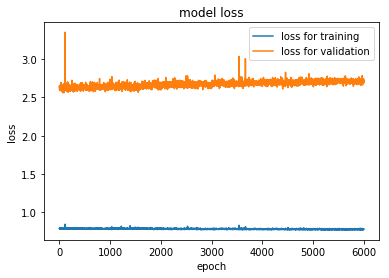

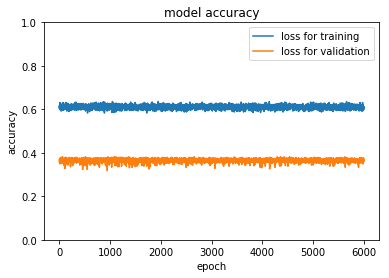

In [65]:
# プロットして損失値と精度の推移を視覚化するのは非常に重要な作業なので特に理由がなければ毎度表示する。
# 過学習や学習不足が確認できる。


# 損失値(Loss)の遷移のプロット
def plot_history_loss(hist):
    
    # hist.historyに辞書型で損失値や精度が入っているので取得して表示
    plt.plot(hist.history['loss'],label="loss for training")
    plt.plot(hist.history['val_loss'],label="loss for validation")
    
    #matplotlibの細かい設定
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='best')
    
    plt.show()

    
# 精度(Accuracy)の遷移のプロット
def plot_history_acc(hist):
    plt.plot(hist.history['acc'],label="loss for training")
    plt.plot(hist.history['val_acc'],label="loss for validation")
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(loc='best')
    plt.ylim([0, 1])
    plt.show()

plot_history_loss(hist)
plot_history_acc(hist)

**全然ダメダメですね。**ダメな原因としては  
・流石にデータが少ない   
・前処理が雑すぎる。URL消すとか、他のハッシュタグを消すとか、ノイズっぽいツイートを消すなどしたい  
・データが少ないのにCNNにする必要性があまりない。普通にMeCabで形態素解析してランダムフォレストとか機械学習アルゴリズムにかけたほうが精度高そう  
・ツイート時期に偏りがあるツイート集合で学習・検証データを作ってしまったので混ぜたほうがよかったかもしれない  
・CNNの設計を考え直すのもいいかもしれない